# Chirp Model: Effects of Changing Direct Current to Excitatory and Inhibitory neurons
<br>
The goal is to modify the parameters of Malerba et al. (2016) CA1 network model in order to afford it the ability to enter into a sustained weak PING oscillation (~55 Hz). Paola mentioned that increasing the density of the E-to-E connections is one way to do this quickly, but in a previous notebook (see ChirpModel_AssessConnectivity.ipynb) the increases in connectivity density between the E-to-E population was not sufficient to generate this sustained, gamma oscillation. Here, I try to change the direct current applied to the pyramidal cell population, in order to increase their baseline excitability. Perhaps a combination of the two (increase in density of connectivity and increase in baseline excitability) will yield the desired network behavior.   
<br>
.

### Double E_dc
<br>
Edc = 2*40 = 80
<br>
Idc = 180
<br>
.

In [80]:
%reset
%load_ext autoreload
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import numpy as np
import scipy as sp

from scipy import signal
from scipy import io as sio

import neurodsp as ndsp
from neurodsp import spectral
from neurodsp import filt

from jupyterthemes import jtplot
jtplot.style()

import matplotlib.pyplot as plt
import seaborn as sns

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [89]:
# TODO: experiment at some point with making the file an input variable

sim01_Edctimes2 = sio.loadmat('sim1_Edctimes2_simdur2sec.mat',squeeze_me=True)

# get the spike times for excitatory and inhibitory neurons
spktimes_e_Edctimes2 = np.atleast_1d(sim01_Edctimes2['tsp_E']['times'])
cell_id_e_Edctimes2 = np.atleast_1d(sim01_Edctimes2['tsp_E']['celln'])

spktimes_i_Edctimes2 = np.atleast_1d(sim01_Edctimes2['tsp_I']['times'])
cell_id_i_Edctimes2 = np.atleast_1d(sim01_Edctimes2['tsp_I']['celln'])

dict_Espktrns_Edctimes2 = {'cell_id':cell_id_e_Edctimes2[0],
               'spktimes':spktimes_e_Edctimes2[0]}
dict_Ispktrns_Edctimes2 = {'cell_id':cell_id_i_Edctimes2[0],
               'spktimes':spktimes_i_Edctimes2[0]}

df_Espktrns_Edctimes2 = pd.DataFrame(dict_Espktrns_Edctimes2)
df_Ispktrns_Edctimes2 = pd.DataFrame(dict_Ispktrns_Edctimes2)

# get the raw lfp
lfp_Edctimes2 = np.atleast_1d(sim01_Edctimes2['lfp'])

# define the time axis & bandpass
fs = 1000 # [=Hz] sampling rate
t = np.arange(len(lfp_Edctimes2))/fs
f_range = (100,300) # [=Hz]

# get the filtered lfp
filt_lfp_ripple_Edctimes2 = filt.filter_signal(lfp_Edctimes2, fs, 'bandpass', f_range)
filt_lfp_higamma_Edctimes2 = filt.filter_signal(lfp_Edctimes2, fs, 'bandpass', f_range_higamma)
filt_lfp_logamma_Edctimes2 = filt.filter_signal(lfp_Edctimes2, fs, 'bandpass', f_range_logamma)

df_lfp_Edctimes2 = pd.DataFrame({'time': t,
                                'lfp': lfp_Edctimes2,
                                'filt lfp': filt_lfp_ripple_Edctimes2,
                       'filt lfp: hi gamma': filt_lfp_higamma_Edctimes2,
                       'filt lfp: lo gamma': filt_lfp_logamma_Edctimes2})


###### ------------------------------------------------------------------------------######
###### ------------------------------------------------------------------------------######

# extract the original network simulation to compare against
sim01_origparams = sio.loadmat('example_2sec.mat',squeeze_me=True)

spktimes_e = np.atleast_1d(sim01_origparams['tsp_E']['times'])
cell_id_e = np.atleast_1d(sim01_origparams['tsp_E']['celln'])

spktimes_i = np.atleast_1d(sim01_origparams['tsp_I']['times'])
cell_id_i = np.atleast_1d(sim01_origparams['tsp_I']['celln'])

dict_Espktrns = {'cell_id':cell_id_e[0],
               'spktimes':spktimes_e[0]}
dict_Ispktrns = {'cell_id':cell_id_i[0],
               'spktimes':spktimes_i[0]}

df_Espktrns = pd.DataFrame(dict_Espktrns)
df_Ispktrns = pd.DataFrame(dict_Ispktrns)

# get the raw and filtered lfp
lfp = np.atleast_1d(sim01_origparams['lfp'])

# get the filtered lfp
f_range_ripple = (100, 300) #[=Hz]
f_range_higamma = (65,95)  #[=Hz]
f_range_logamma = (35,55)  #[=Hz]
f_range_beta = (15,35)  #[=Hz]
f_range_theta = (4,12)  #[=Hz]

filt_lfp_ripple = filt.filter_signal(lfp, fs, 'bandpass', f_range_ripple)
filt_lfp_higamma = filt.filter_signal(lfp, fs, 'bandpass', f_range_higamma)
filt_lfp_logamma = filt.filter_signal(lfp, fs, 'bandpass', f_range_logamma)

df_lfp = pd.DataFrame({'time': t,
                       'lfp': lfp,
                       'filt lfp: ripple': filt_lfp_ripple,
                       'filt lfp: hi gamma': filt_lfp_higamma,
                       'filt lfp: lo gamma': filt_lfp_logamma})



Transition bandwidth is 43.9 Hz. Pass/stop bandwidth is 200 Hz
Transition bandwidth is 21.5 Hz. Pass/stop bandwidth is 30 Hz
Transition bandwidth is 12.7 Hz. Pass/stop bandwidth is 20 Hz
Transition bandwidth is 43.9 Hz. Pass/stop bandwidth is 200 Hz
Transition bandwidth is 21.5 Hz. Pass/stop bandwidth is 30 Hz
Transition bandwidth is 12.7 Hz. Pass/stop bandwidth is 20 Hz


(0, 1.0)

<Figure size 460.8x403.2 with 0 Axes>

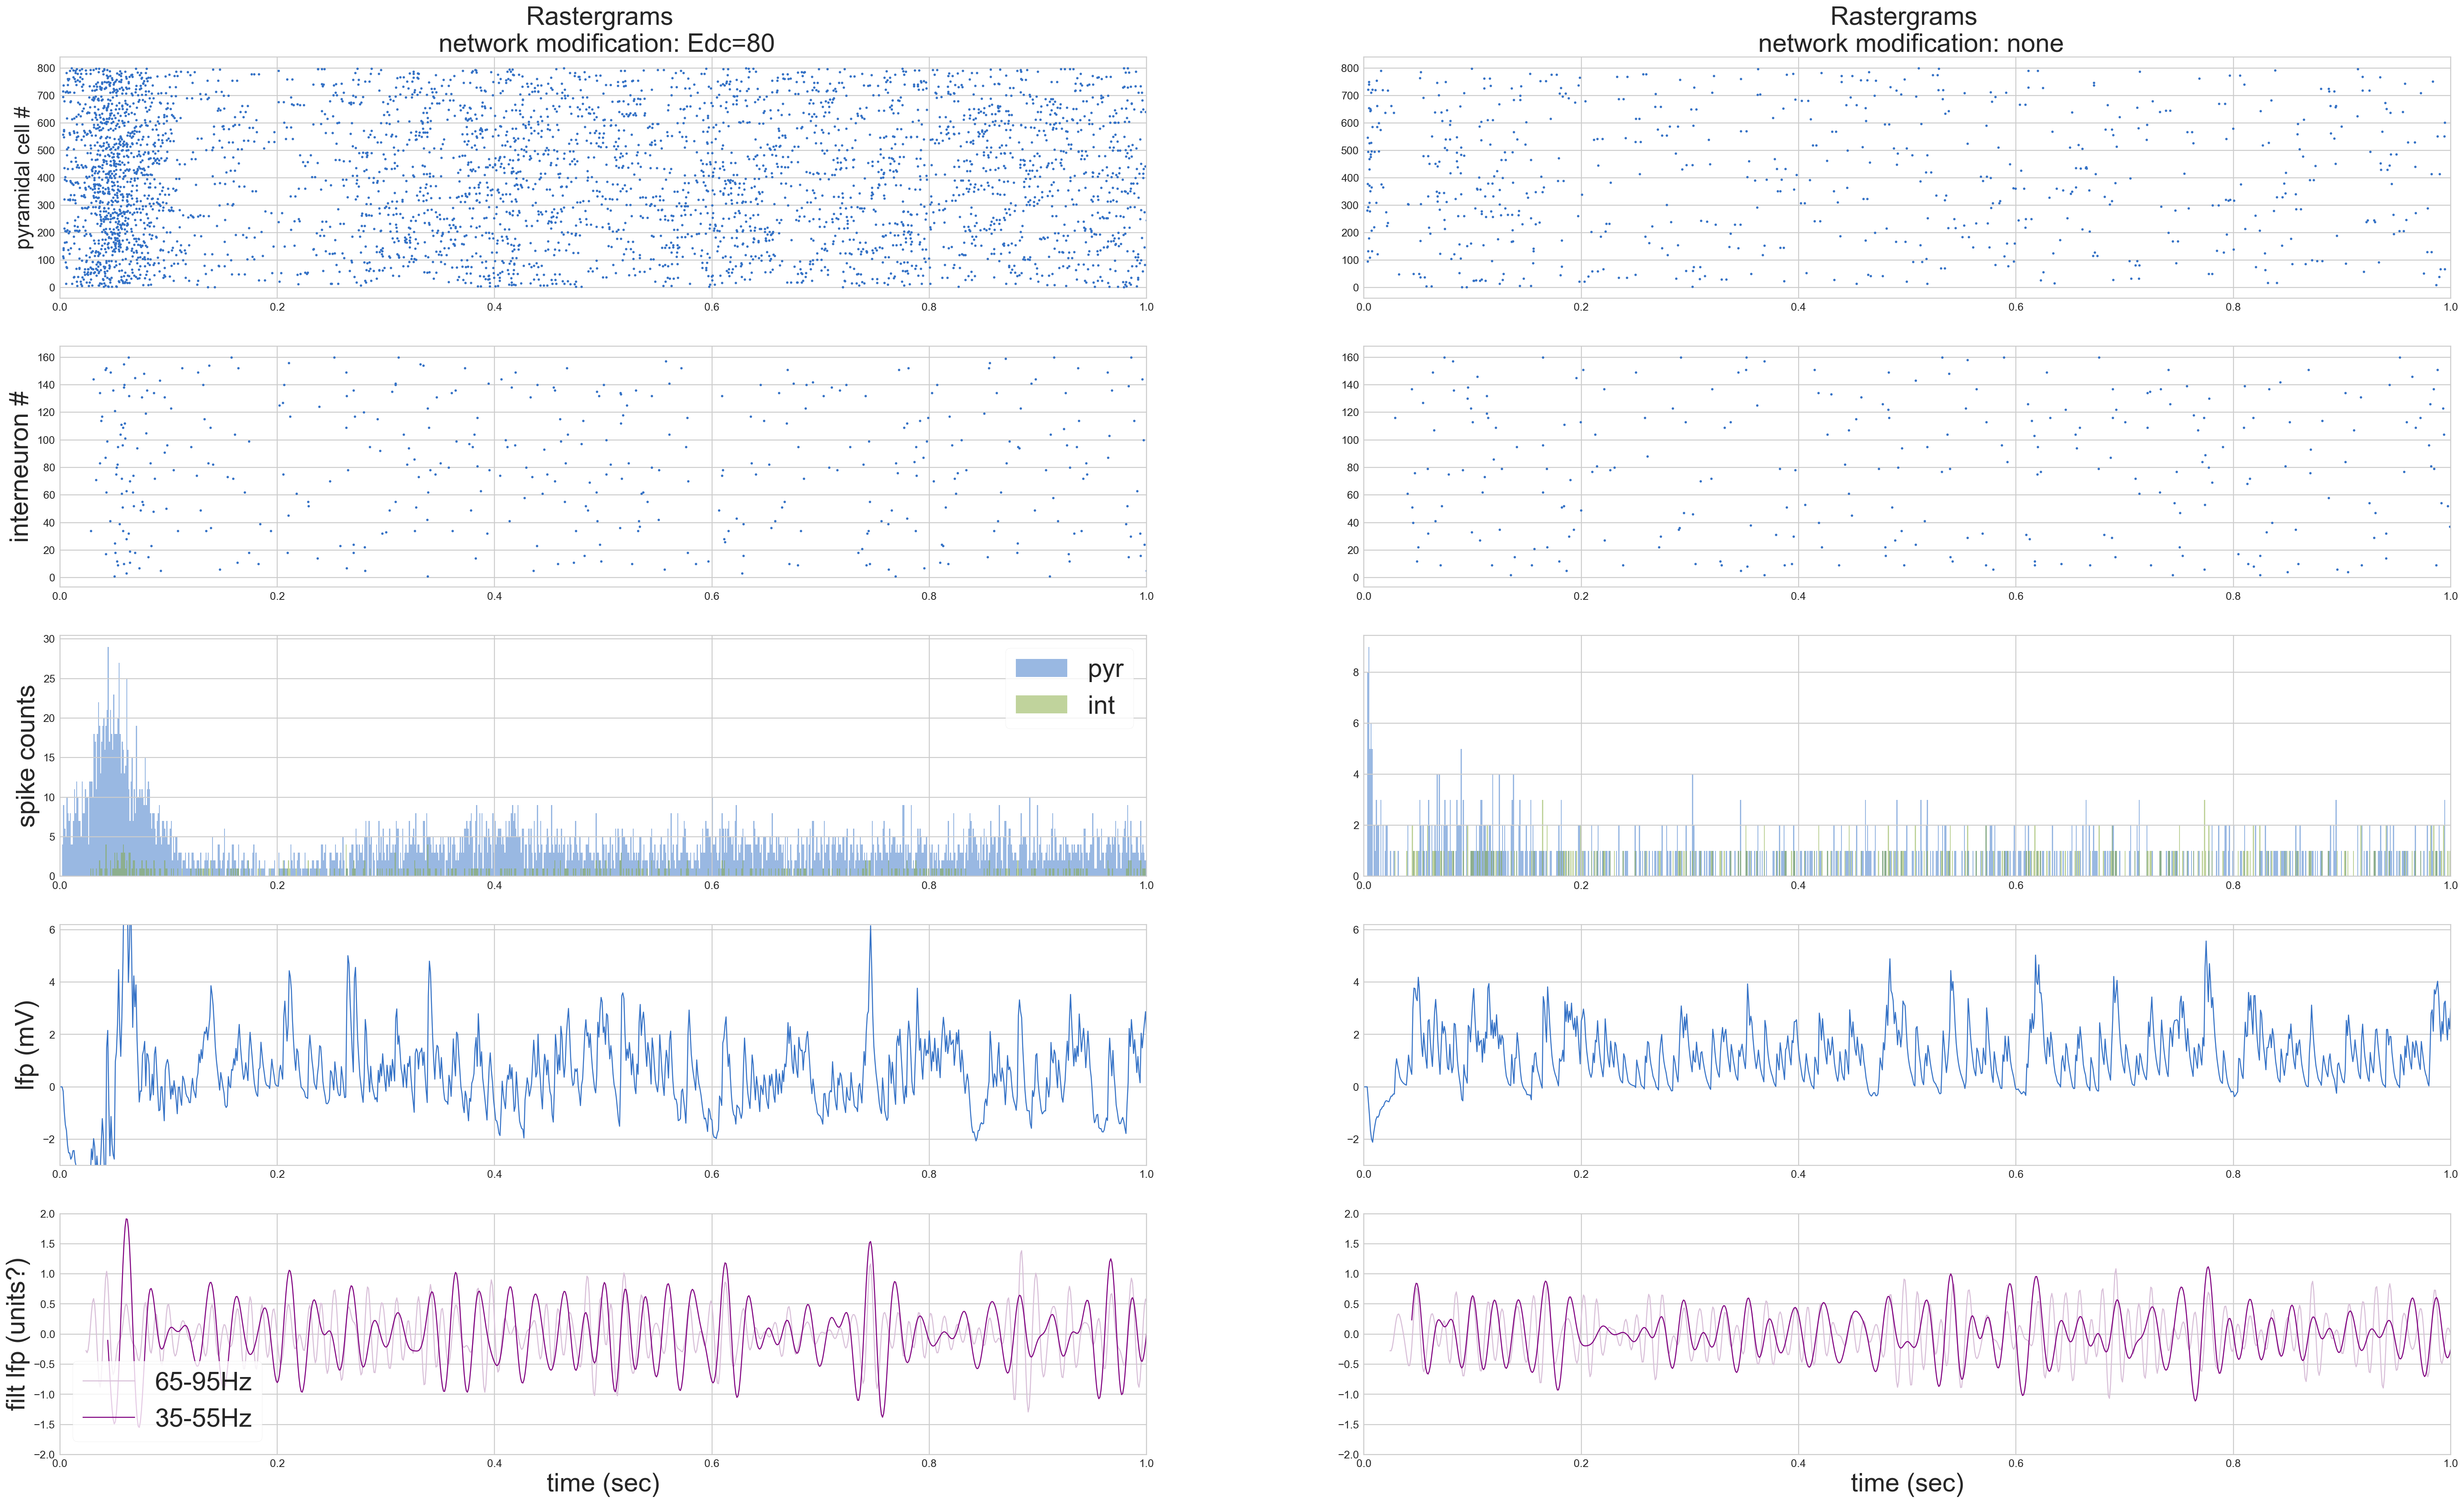

In [109]:
ts = 1.0;    # window duration

plt.figure()
plt.figure(figsize=(50,30))
plt.tick_params(axis='both',labelsize=20)
# ----------------------------plot pyr cell rasters----------------------------------------
rescale_x = (0, ts);

df_Espktrns_Edctimes2_partial = df_Espktrns_Edctimes2[df_Espktrns_Edctimes2['spktimes']<=ts]
plt.subplot(5,2,1)
plt.plot(df_Espktrns_Edctimes2_partial['spktimes'], df_Espktrns_Edctimes2_partial['cell_id'],'.')
plt.ylabel('pyramidal cell #',fontsize=24)
plt.xlim(rescale_x)
plt.title('Rastergrams \n network modification: Edc=80',fontsize=30)

df_Espktrns_partial = df_Espktrns[df_Espktrns['spktimes']<=ts]
plt.subplot(5,2,2)
plt.plot(df_Espktrns['spktimes'], df_Espktrns['cell_id'],'.')
plt.xlim(rescale_x)
plt.title('Rastergrams \n network modification: none',fontsize=30)

# ----------------------------plot interneuron rasters--------------------------------------

df_Ispktrns_Edctimes2_partial = df_Ispktrns_Edctimes2[df_Ispktrns_Edctimes2['spktimes']<=ts]
plt.subplot(5,2,3)
plt.plot(df_Ispktrns_Edctimes2['spktimes'], df_Ispktrns_Edctimes2['cell_id'],'.')
plt.ylabel('interneuron #',fontsize=30)
plt.xlim(rescale_x)

df_Ispktrns_partial = df_Ispktrns[df_Ispktrns['spktimes']<=ts]
plt.subplot(5,2,4)
plt.plot(df_Ispktrns['spktimes'], df_Ispktrns['cell_id'],'.')
plt.xlim(rescale_x)

# ----------------------------plot spike histograms--------------------------------------

plt.subplot(5,2,5)
plt.hist(df_Espktrns_Edctimes2_partial['spktimes'],t,alpha=0.5,label='pyr')
plt.hist(df_Ispktrns_Edctimes2_partial['spktimes'],t,alpha=0.5,label='int')
plt.legend(loc='upper right',fontsize=30)
plt.ylabel('spike counts',fontsize=30)
plt.xlim(rescale_x)

plt.subplot(5,2,6)
plt.hist(df_Espktrns_partial['spktimes'],t,alpha=0.5)
plt.hist(df_Ispktrns_partial['spktimes'],t,alpha=0.5)
plt.xlim(rescale_x)


# ----------------------------plot raw lfp--------------------------------------------------
rescale_y = (-3.0, 6.2);

df_lfp_Edctimes2_partial = df_lfp_Edctimes2[df_lfp_Edctimes2['time']<=ts]
plt.subplot(5,2,7)
plt.plot(df_lfp_Edctimes2_partial['time'],df_lfp_Edctimes2_partial['lfp'])
plt.ylabel('lfp (mV)',fontsize=30)
plt.ylim(rescale_y)
plt.xlim(rescale_x)

df_lfp_partial = df_lfp[df_lfp['time']<=ts]
plt.subplot(5,2,8)
plt.plot(df_lfp_partial['time'], df_lfp_partial['lfp'])
plt.ylim(rescale_y)
plt.xlim(rescale_x)

# ----------------------------plot filtered lfp----------------------------------------------
rescale_y = (-2.0, 2.0);

plt.subplot(5,2,9)
plt.plot(df_lfp_Edctimes2_partial['time'],df_lfp_Edctimes2_partial['filt lfp: hi gamma'],color='thistle')
plt.plot(df_lfp_Edctimes2_partial['time'],df_lfp_Edctimes2_partial['filt lfp: lo gamma'],color='purple')
plt.ylabel('filt lfp (units?)',fontsize=30)
plt.xlabel('time (sec)',fontsize=30)
plt.legend((f1[0],f2[0]),('65-95Hz','35-55Hz'),fontsize=30)
plt.ylim(rescale_y)
plt.xlim(rescale_x)

plt.subplot(5,2,10)
f1 = plt.plot(df_lfp_partial['time'],df_lfp_partial['filt lfp: hi gamma'],color='thistle')
f2 = plt.plot(df_lfp_partial['time'],df_lfp_partial['filt lfp: lo gamma'],color='purple')
plt.xlabel('time (sec)',fontsize=30)
plt.ylim(rescale_y)
plt.xlim(rescale_x)


### Quadruple Edc
<br>
Edc = 4*40 = 160
<br>
Idc = 180
<br>
.

In [114]:
# get spiketimes for excitatory and inhibitory neurons
sim01_Edctimes4 = sio.loadmat('sim1_Edctimes4_simdur2sec.mat',squeeze_me=True)

spktimes_e_Edctimes4 = np.atleast_1d(sim01_Edctimes4['tsp_E']['times'])
cell_id_e_Edctimes4 = np.atleast_1d(sim01_Edctimes4['tsp_E']['celln'])

spktimes_i_Edctimes4 = np.atleast_1d(sim01_Edctimes4['tsp_I']['times'])
cell_id_i_Edctimes4 = np.atleast_1d(sim01_Edctimes4['tsp_I']['celln'])

dict_Espktrns_Edctimes4 = {'cell_id':cell_id_e_Edctimes4[0],
               'spktimes':spktimes_e_Edctimes4[0]}
dict_Ispktrns_Edctimes4 = {'cell_id':cell_id_i_Edctimes4[0],
               'spktimes':spktimes_i_Edctimes4[0]}

df_Espktrns_Edctimes4 = pd.DataFrame(dict_Espktrns_Edctimes4)
df_Ispktrns_Edctimes4 = pd.DataFrame(dict_Ispktrns_Edctimes4)

# get raw and filtered lfps
lfp_Edctimes4 = np.atleast_1d(sim01_Edctimes4['lfp'])
filt_lfp_ripple_Edctimes4 = filt.filter_signal(lfp_Edctimes4, fs, 'bandpass', f_range)
filt_lfp_higamma_Edctimes4 = filt.filter_signal(lfp_Edctimes4, fs, 'bandpass', f_range_higamma)
filt_lfp_logamma_Edctimes4 = filt.filter_signal(lfp_Edctimes4, fs, 'bandpass', f_range_logamma)

df_lfp = pd.DataFrame({'time': t,
                       'lfp': lfp,
                       'filt lfp: ripple': filt_lfp_ripple,
                       'filt lfp: hi gamma': filt_lfp_higamma,
                       'filt lfp: lo gamma': filt_lfp_logamma})

df_lfp_Edctimes4 = pd.DataFrame({'time': t,
                                'lfp': lfp_Edctimes4,
                                'filt lfp': filt_lfp_ripple_Edctimes4,
                       'filt lfp: hi gamma': filt_lfp_higamma_Edctimes4,
                       'filt lfp: lo gamma': filt_lfp_logamma_Edctimes4})


Transition bandwidth is 43.9 Hz. Pass/stop bandwidth is 200 Hz
Transition bandwidth is 21.5 Hz. Pass/stop bandwidth is 30 Hz
Transition bandwidth is 12.7 Hz. Pass/stop bandwidth is 20 Hz


(0, 1.0)

<Figure size 460.8x403.2 with 0 Axes>

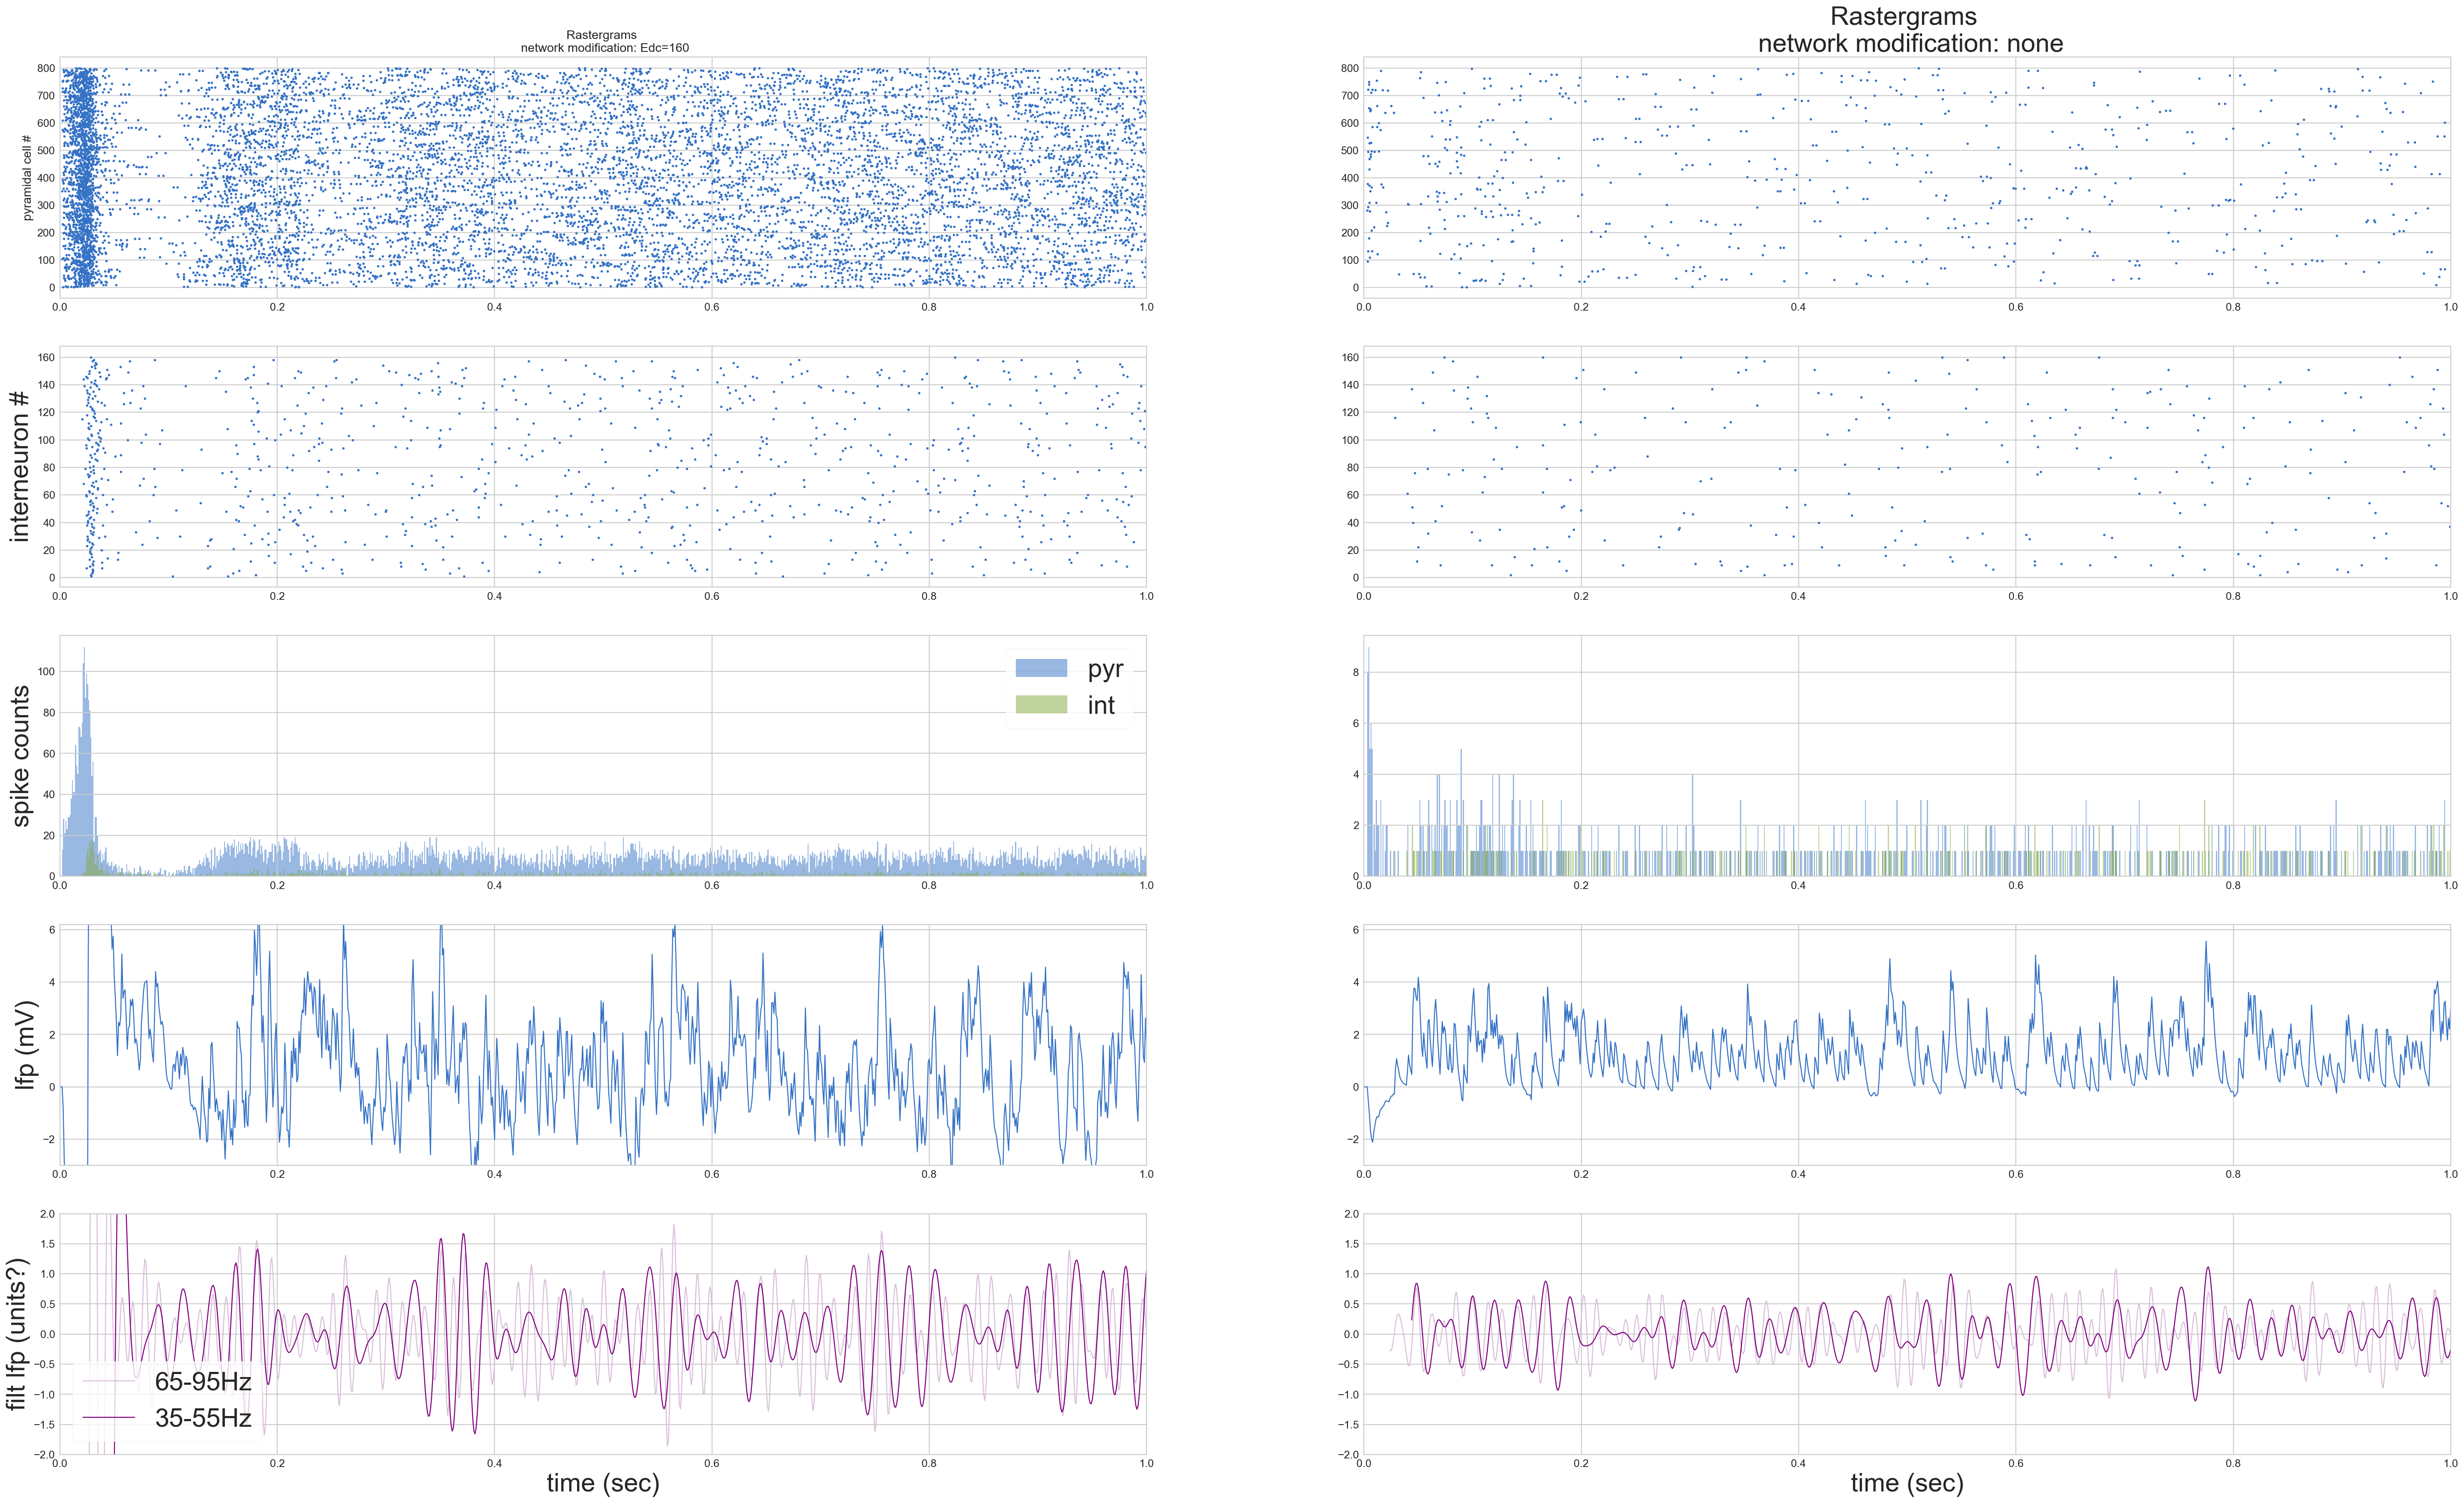

In [115]:
ts = 1.0;    # window duration

plt.figure()
plt.figure(figsize=(50,30))
plt.tick_params(axis='both',labelsize=20)

# ----------------------------plot pyr cell rasters----------------------------------------
rescale_x = (0, ts);

df_Espktrns_Edctimes4_partial = df_Espktrns_Edctimes4[df_Espktrns_Edctimes4['spktimes']<=ts]
plt.subplot(5,2,1)
plt.plot(df_Espktrns_Edctimes4_partial['spktimes'], df_Espktrns_Edctimes4_partial['cell_id'],'.')
plt.ylabel('pyramidal cell #',fontsize=30)
plt.title('Rastergrams \n network modification: Edc=160',fontsize=30)
plt.xlim(rescale_x)

df_Espktrns_partial = df_Espktrns[df_Espktrns['spktimes']<=ts]
plt.subplot(5,2,2)
plt.plot(df_Espktrns['spktimes'], df_Espktrns['cell_id'],'.')
plt.xlim(rescale_x)
plt.title('Rastergrams \n network modification: none',fontsize=30)
plt.xlim(rescale_x)

# ----------------------------plot interneuron rasters--------------------------------------

df_Ispktrns_Edctimes4_partial = df_Ispktrns_Edctimes4[df_Ispktrns_Edctimes4['spktimes']<=ts]
plt.subplot(5,2,3)
plt.plot(df_Ispktrns_Edctimes4['spktimes'], df_Ispktrns_Edctimes4['cell_id'],'.')
plt.ylabel('interneuron #',fontsize=30)
plt.xlim(rescale_x)

df_Ispktrns_partial = df_Ispktrns[df_Ispktrns['spktimes']<=ts]
plt.subplot(5,2,4)
plt.plot(df_Ispktrns['spktimes'], df_Ispktrns['cell_id'],'.')
plt.xlim(rescale_x)

# ----------------------------plot spike histograms--------------------------------------

plt.subplot(5,2,5)
plt.hist(df_Espktrns_Edctimes4_partial['spktimes'],t,alpha=0.5,label='pyr')
plt.hist(df_Ispktrns_Edctimes4_partial['spktimes'],t,alpha=0.5,label='int')
plt.legend(loc='upper right',fontsize=30)
plt.ylabel('spike counts',fontsize=30)
plt.xlim(rescale_x)

plt.subplot(5,2,6)
plt.hist(df_Espktrns_partial['spktimes'],t,alpha=0.5)
plt.hist(df_Ispktrns_partial['spktimes'],t,alpha=0.5)
plt.xlim(rescale_x)

# ----------------------------plot raw lfp--------------------------------------------------
rescale_y = (-3.0, 6.2);

df_lfp_Edctimes4_partial = df_lfp_Edctimes4[df_lfp_Edctimes4['time']<=ts]
plt.subplot(5,2,7)
plt.plot(df_lfp_Edctimes4_partial['time'],df_lfp_Edctimes4_partial['lfp'])
plt.ylabel('lfp (mV)',fontsize=30)
plt.ylim(rescale_y)
plt.xlim(rescale_x)

df_lfp_partial = df_lfp[df_lfp['time']<=ts]
plt.subplot(5,2,8)
plt.plot(df_lfp_partial['time'], df_lfp_partial['lfp'])
plt.ylim(rescale_y)
plt.xlim(rescale_x)

# ----------------------------plot filtered lfp----------------------------------------------
rescale_y = (-2.0, 2.0);

plt.subplot(5,2,9)
plt.plot(df_lfp_Edctimes4_partial['time'],df_lfp_Edctimes4_partial['filt lfp: hi gamma'],color='thistle')
plt.plot(df_lfp_Edctimes4_partial['time'],df_lfp_Edctimes4_partial['filt lfp: lo gamma'],color='purple')
plt.ylabel('filt lfp (units?)',fontsize=30)
plt.xlabel('time (sec)',fontsize=30)
plt.legend((f1[0],f2[0]),('65-95Hz','35-55Hz'),fontsize=30)
plt.ylim(rescale_y)
plt.xlim(rescale_x)

plt.subplot(5,2,10)
f1 = plt.plot(df_lfp_partial['time'],df_lfp_partial['filt lfp: hi gamma'],color='thistle')
f2 = plt.plot(df_lfp_partial['time'],df_lfp_partial['filt lfp: lo gamma'],color='purple')
plt.xlabel('time (sec)',fontsize=30)
plt.ylim(rescale_y)
plt.xlim(rescale_x)



### Edc same as Idc
<br>
Edc = 180
<br>
Idc = 180
<br>
.

In [24]:
sim01_EdcsameasIdc = sio.loadmat('sim1_EdcsameasIdc_simdur2sec.mat',squeeze_me=True)

spktimes_e_EdcsameasIdc = np.atleast_1d(sim01_EdcsameasIdc['tsp_E']['times'])
cell_id_e_EdcsameasIdc = np.atleast_1d(sim01_EdcsameasIdc['tsp_E']['celln'])

spktimes_i_EdcsameasIdc = np.atleast_1d(sim01_EdcsameasIdc['tsp_I']['times'])
cell_id_i_EdcsameasIdc = np.atleast_1d(sim01_EdcsameasIdc['tsp_I']['celln'])

dict_Espktrns_EdcsameasIdc = {'cell_id':cell_id_e_EdcsameasIdc[0],
               'spktimes':spktimes_e_EdcsameasIdc[0]}
dict_Ispktrns_EdcsameasIdc = {'cell_id':cell_id_i_EdcsameasIdc[0],
               'spktimes':spktimes_i_EdcsameasIdc[0]}

df_Espktrns_EdcsameasIdc = (dict_Espktrns_EdcsameasIdc)
df_Ispktrns_EdcsameasIdc = (dict_Ispktrns_EdcsameasIdc)

# get raw and filtered lfps
lfp_EdcsameasIdc = np.atleast_1d(sim01_EdcsameasIdc['lfp'])
filt_lfp_EdcsameasIdc = filt.filter_signal(lfp_EdcsameasIdc, fs, 'bandpass', f_range)

df_lfp_EdcsameasIdc = pd.DataFrame({'time': t,
                                'lfp': lfp_EdcsameasIdc,
                                'filt lfp': filt_lfp_EdcsameasIdc})

Transition bandwidth is 43.9 Hz. Pass/stop bandwidth is 200 Hz


<Figure size 460.8x403.2 with 0 Axes>

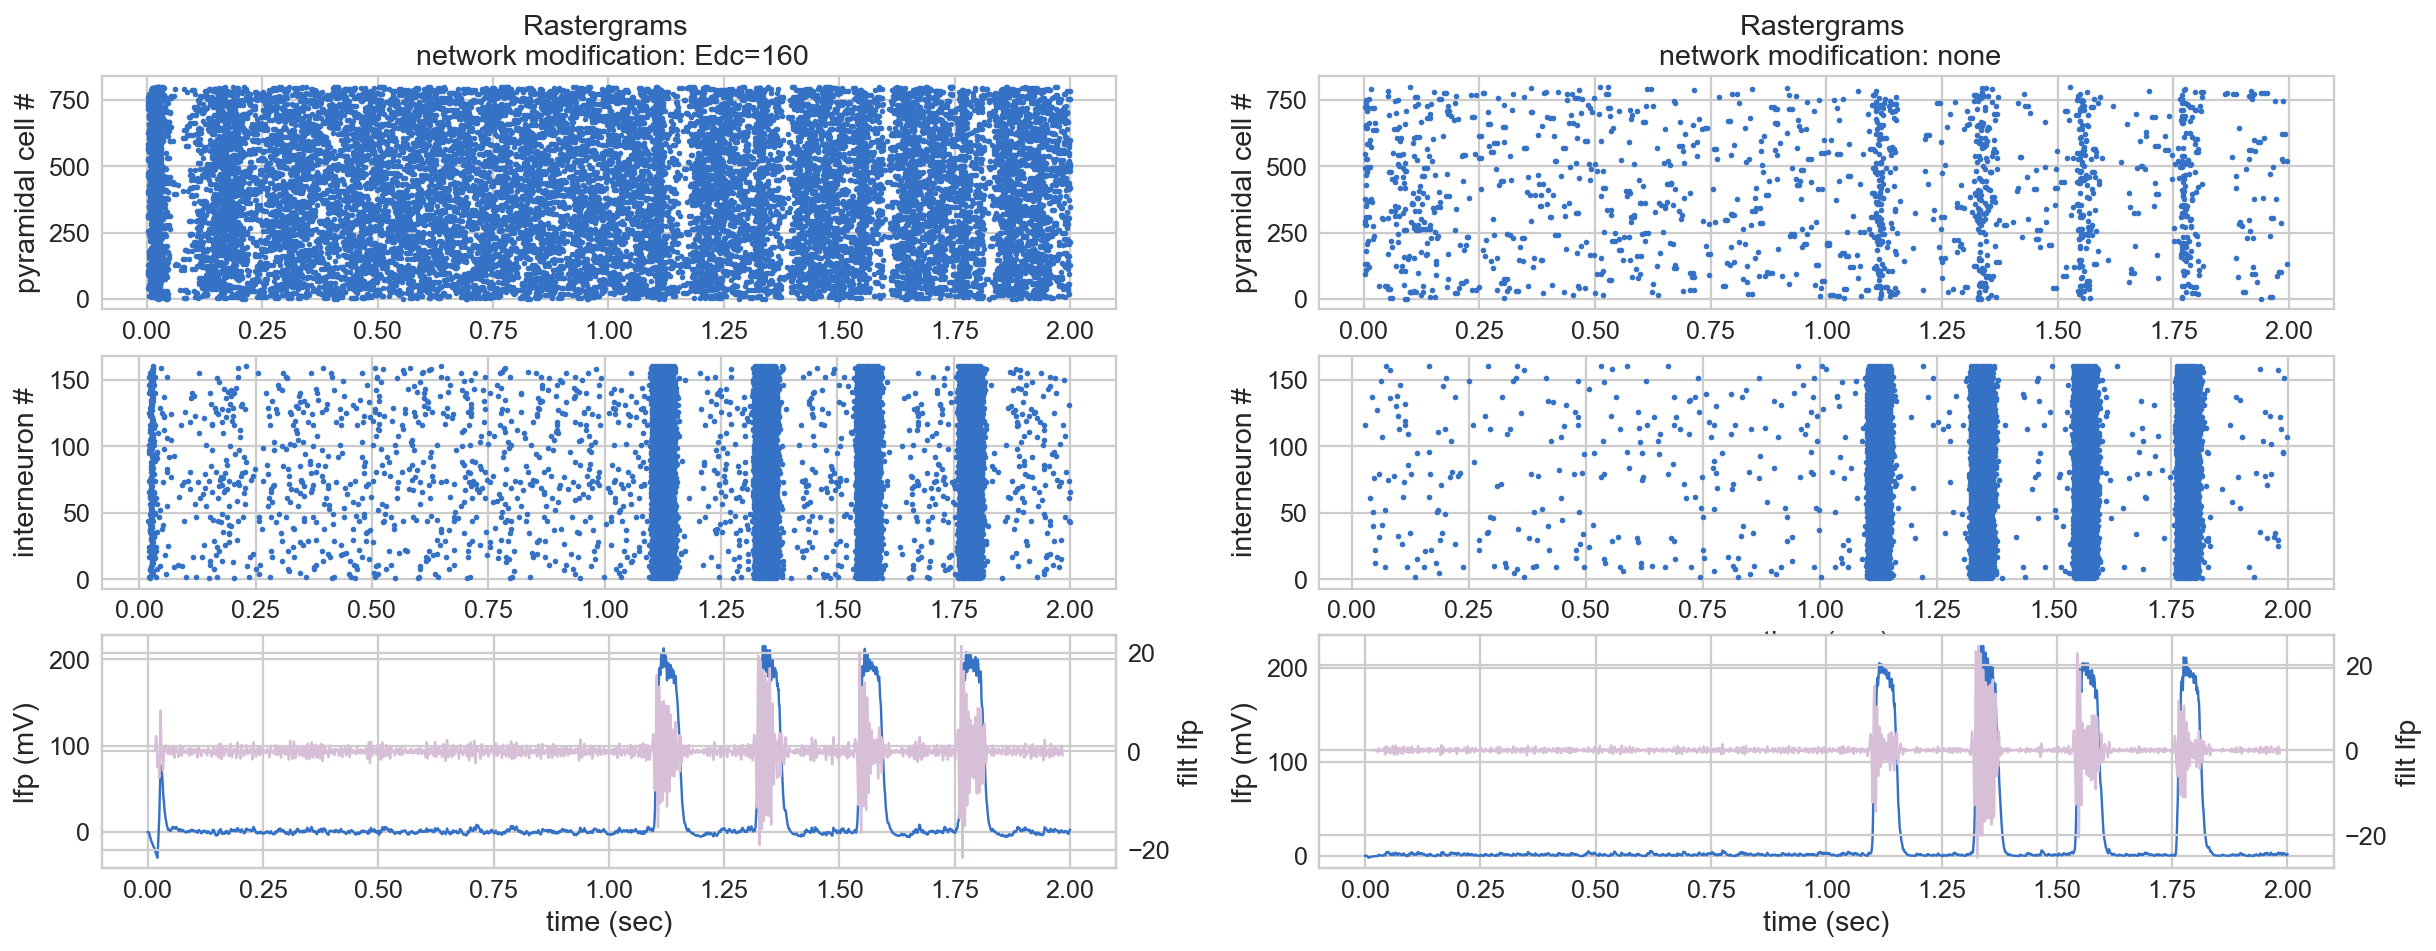

In [25]:
plt.figure()
plt.figure(figsize=(20,15))

plt.subplot(6,2,1)
plt.plot(df_Espktrns_EdcsameasIdc['spktimes'], df_Espktrns_EdcsameasIdc['cell_id'],'.')
plt.ylabel('pyramidal cell #')
plt.title('Rastergrams \n network modification: Edc=160')

plt.subplot(6,2,3)
plt.plot(df_Ispktrns_EdcsameasIdc['spktimes'], df_Ispktrns_EdcsameasIdc['cell_id'],'.')
plt.ylabel('interneuron #')

plt.subplot(6,2,2)
plt.plot(df_Espktrns['spktimes'], df_Espktrns['cell_id'],'.')
plt.ylabel('pyramidal cell #')
plt.title('Rastergrams \n network modification: none')

plt.subplot(6,2,4)
plt.plot(df_Ispktrns['spktimes'], df_Ispktrns['cell_id'],'.')
plt.ylabel('interneuron #')
plt.xlabel('time (sec)')

ax1 = plt.subplot(6,2,5)
plt.plot(df_lfp_EdcsameasIdc['time'], df_lfp_EdcsameasIdc['lfp'])
plt.ylabel('lfp (mV)')
plt.xlabel('time (sec)')
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('filt lfp')  # we already handled the x-label with ax1
ax2.plot(df_lfp_EdcsameasIdc['time'],df_lfp_EdcsameasIdc['filt lfp'],color='thistle')

ax1 = plt.subplot(6,2,6)
plt.plot(df_lfp['time'], df_lfp['lfp'])
plt.ylabel('lfp (mV)')
plt.xlabel('time (sec)')
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('filt lfp')  # we already handled the x-label with ax1
ax2.plot(df_lfp['time'],df_lfp['filt lfp: ripple'],color='thistle')


### Double Idc
Note from Paola meeting: "progressively depolarize DC params BOTH E & I, have them chase each other" 
<br>
<br>
Interpreted this to mean that I am to now increase the direct current regulating interneuron baseline excitability for each of the three changes I made to pyramidal neuron direct current.
<br>
<br>
Edc = 40
<br>
Idc = 2*180 = 360
<br>
.

In [26]:
sim01_Idctimes2 = sio.loadmat('sim1_Idctimes2_simdur2sec.mat',squeeze_me=True)

spktimes_e_Idctimes2 = np.atleast_1d(sim01_Idctimes2['tsp_E']['times'])
cell_id_e_Idctimes2 = np.atleast_1d(sim01_Idctimes2['tsp_E']['celln'])

spktimes_i_Idctimes2 = np.atleast_1d(sim01_Idctimes2['tsp_I']['times'])
cell_id_i_Idctimes2 = np.atleast_1d(sim01_Idctimes2['tsp_I']['celln'])

dict_Espktrns_Idctimes2 = {'cell_id':cell_id_e_Idctimes2[0],
               'spktimes':spktimes_e_Idctimes2[0]}
dict_Ispktrns_Idctimes2 = {'cell_id':cell_id_i_Idctimes2[0],
               'spktimes':spktimes_i_Idctimes2[0]}

df_Espktrns_Idctimes2 = (dict_Espktrns_Idctimes2)
df_Ispktrns_Idctimes2 = (dict_Ispktrns_Idctimes2)

# get raw and filtered lfps
lfp_Idctimes2 = np.atleast_1d(sim01_Idctimes2['lfp'])

f_range_ripple = (100, 300) #[=Hz]
f_range_higamma = (65,95)  #[=Hz]
f_range_logamma = (35,55)  #[=Hz]

filt_lfp_ripple_Idctimes2 = filt.filter_signal(lfp_Idctimes2, fs, 'bandpass', f_range_ripple)
filt_lfp_higamma_Idctimes2 = filt.filter_signal(lfp_Idctimes2, fs, 'bandpass', f_range_higamma)
filt_lfp_logamma_Idctimes2 = filt.filter_signal(lfp_Idctimes2, fs, 'bandpass', f_range_logamma)

df_lfp_Idctimes2 = pd.DataFrame({'time': t,
                                'lfp': lfp_Idctimes2,
                                'filt lfp: ripple': filt_lfp_ripple_Idctimes2,
                                'filt lfp: hi gamma': filt_lfp_higamma_Idctimes2,
                                'filt lfp: lo gamma': filt_lfp_logamma_Idctimes2})

Transition bandwidth is 43.9 Hz. Pass/stop bandwidth is 200 Hz
Transition bandwidth is 21.5 Hz. Pass/stop bandwidth is 30 Hz
Transition bandwidth is 12.7 Hz. Pass/stop bandwidth is 20 Hz


<Figure size 460.8x403.2 with 0 Axes>

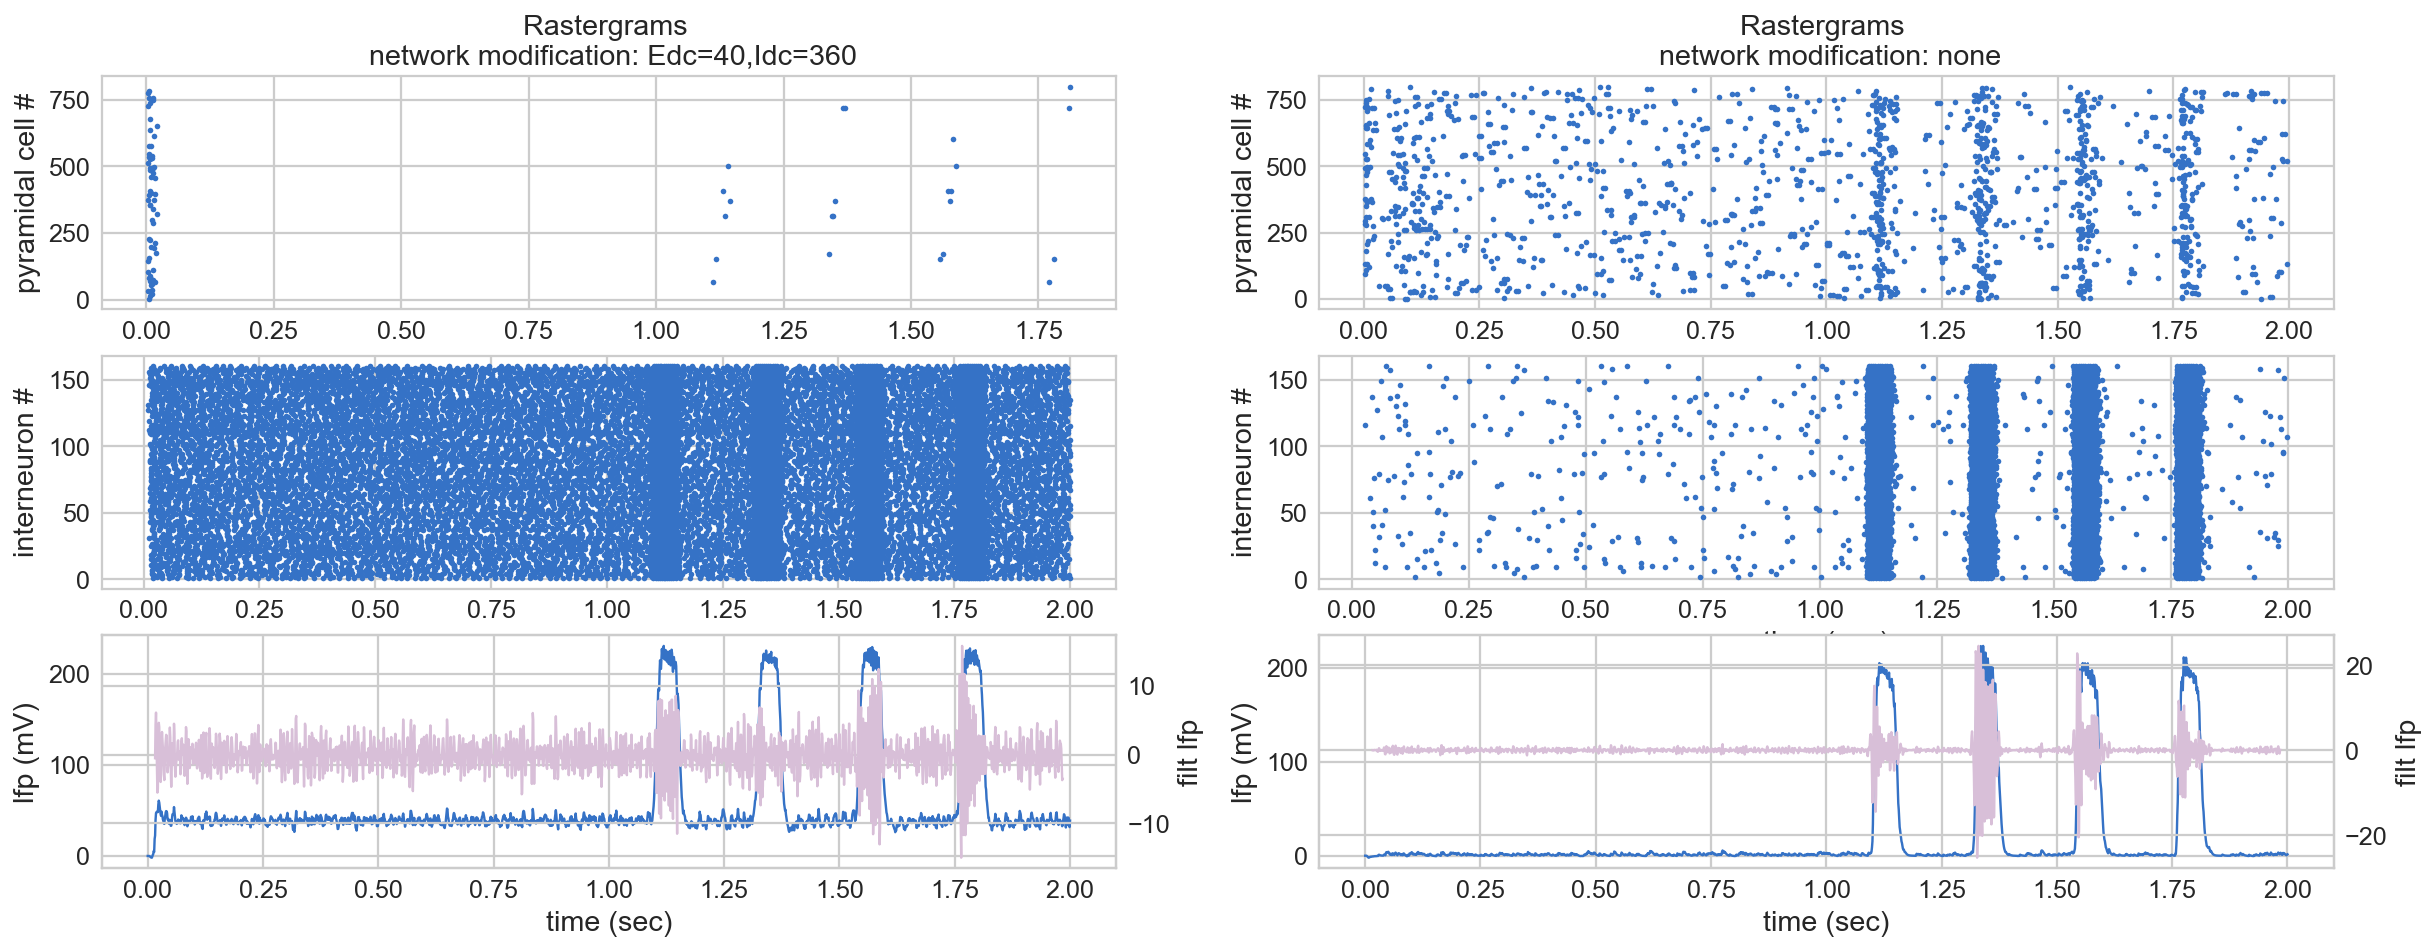

In [27]:
plt.figure()
plt.figure(figsize=(20,15))

plt.subplot(6,2,1)
plt.plot(df_Espktrns_Idctimes2['spktimes'], df_Espktrns_Idctimes2['cell_id'],'.')
plt.ylabel('pyramidal cell #')
plt.title('Rastergrams \n network modification: Edc=40,Idc=360')

plt.subplot(6,2,3)
plt.plot(df_Ispktrns_Idctimes2['spktimes'], df_Ispktrns_Idctimes2['cell_id'],'.')
plt.ylabel('interneuron #')

plt.subplot(6,2,2)
plt.plot(df_Espktrns['spktimes'], df_Espktrns['cell_id'],'.')
plt.ylabel('pyramidal cell #')
plt.title('Rastergrams \n network modification: none')

plt.subplot(6,2,4)
plt.plot(df_Ispktrns['spktimes'], df_Ispktrns['cell_id'],'.')
plt.ylabel('interneuron #')
plt.xlabel('time (sec)')

ax1 = plt.subplot(6,2,5)
plt.plot(df_lfp_Idctimes2['time'], df_lfp_Idctimes2['lfp'])
plt.ylabel('lfp (mV)')
plt.xlabel('time (sec)')
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('filt lfp')  # we already handled the x-label with ax1
ax2.plot(df_lfp_Idctimes2['time'],df_lfp_Idctimes2['filt lfp: ripple'],color='thistle')

ax1 = plt.subplot(6,2,6)
plt.plot(df_lfp['time'], df_lfp['lfp'])
plt.ylabel('lfp (mV)')
plt.xlabel('time (sec)')
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('filt lfp')  # we already handled the x-label with ax1
ax2.plot(df_lfp['time'],df_lfp['filt lfp: ripple'],color='thistle')


.
<br>
<br>
Visual inspection of raw and filtered traces above for the modified network suggest that some sustained baseline oscillation _might_ be present. Does the modified network yield, to a first approximation, larger-amplitude and more sustained high and low gamma frequencies? To check, I've plotted the raw and filtered traces below (for single network simulations of original and modified networks). 
<br>
<br>
.


<Figure size 460.8x403.2 with 0 Axes>

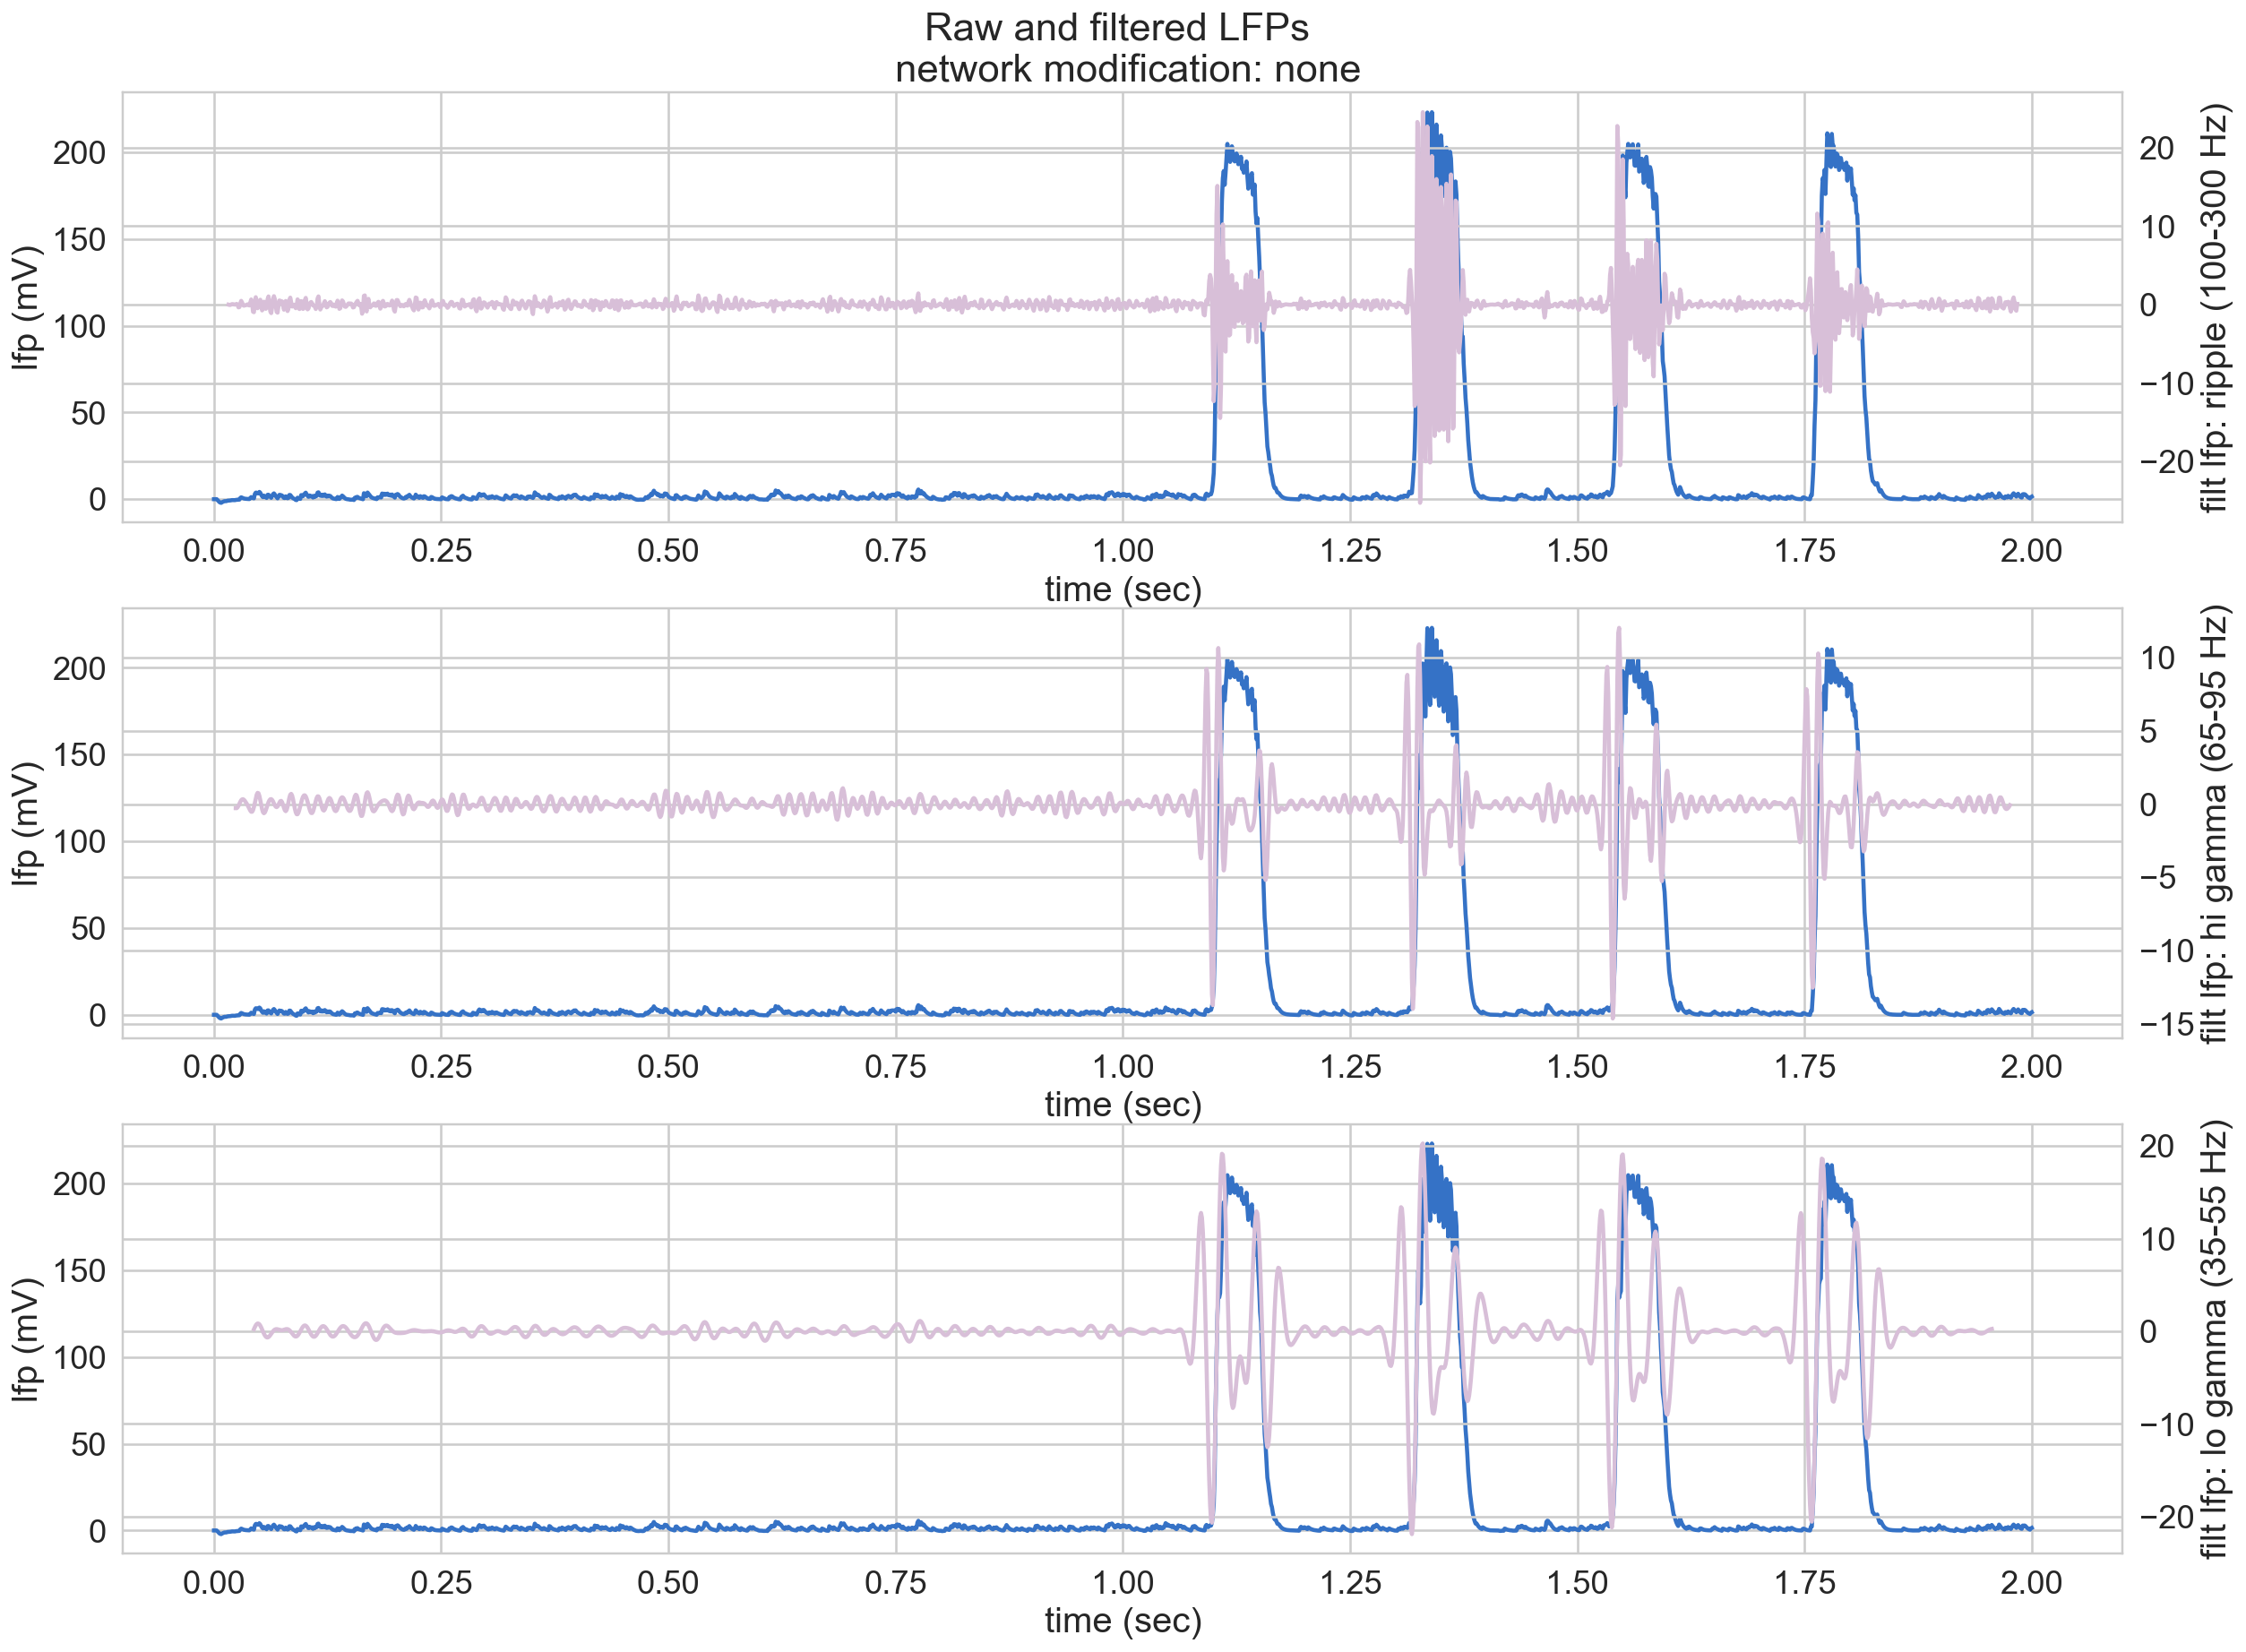

In [28]:
plt.figure()
plt.figure(figsize=(20,15))
sns.set_context("talk", font_scale=1.4)

ax1 = plt.subplot(3,1,1)
plt.plot(df_lfp['time'], df_lfp['lfp'])
plt.ylabel('lfp (mV)')
plt.xlabel('time (sec)')
plt.title('Raw and filtered LFPs \n network modification: none')
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('filt lfp: ripple (100-300 Hz)')  # we already handled the x-label with ax1
ax2.plot(df_lfp_Idctimes2['time'],df_lfp['filt lfp: ripple'],color='thistle')

ax1 = plt.subplot(3,1,2)
plt.plot(df_lfp['time'], df_lfp['lfp'])
plt.ylabel('lfp (mV)')
plt.xlabel('time (sec)')
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('filt lfp: hi gamma (65-95 Hz)')  # we already handled the x-label with ax1
ax2.plot(df_lfp['time'],df_lfp['filt lfp: hi gamma'],color='thistle')

ax1 = plt.subplot(3,1,3)
plt.plot(df_lfp['time'], df_lfp['lfp'])
plt.ylabel('lfp (mV)')
plt.xlabel('time (sec)')
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('filt lfp: lo gamma (35-55 Hz)')  # we already handled the x-label with ax1
ax2.plot(df_lfp['time'],df_lfp['filt lfp: lo gamma'],color='thistle')




<Figure size 460.8x403.2 with 0 Axes>

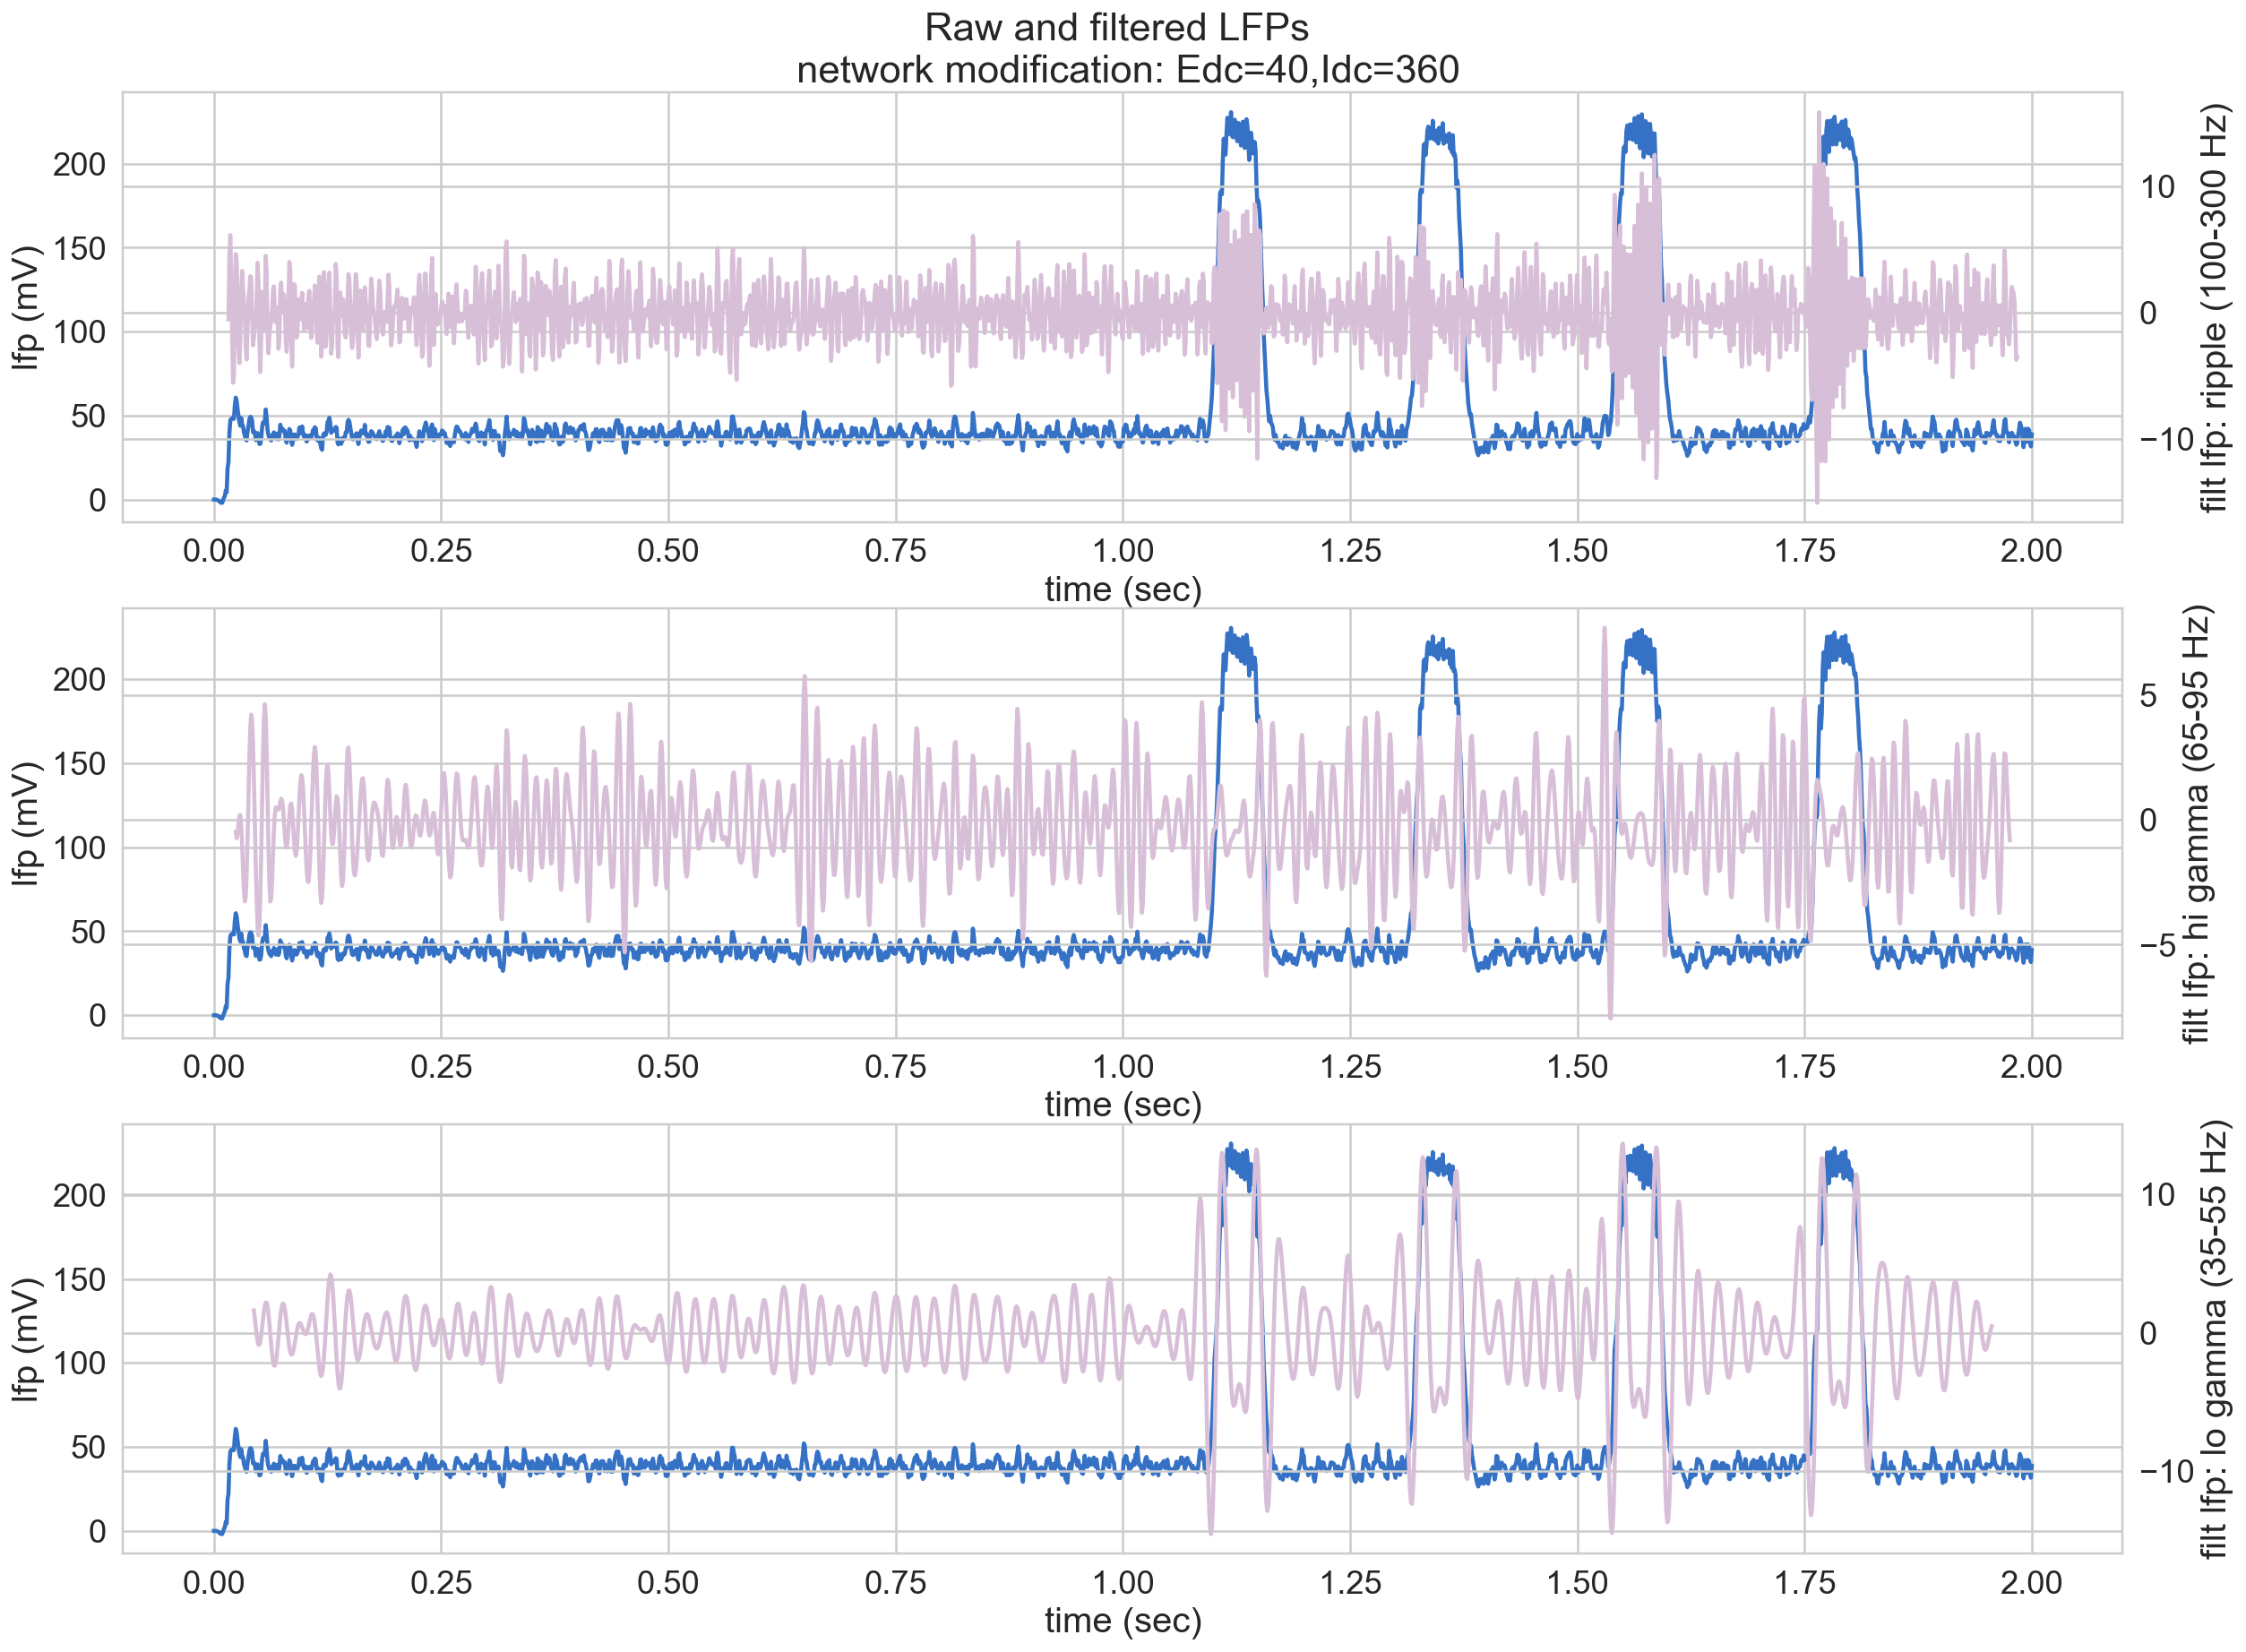

In [29]:
plt.figure()
plt.figure(figsize=(20,15))
sns.set_context("talk", font_scale=1.4)

ax1 = plt.subplot(3,1,1)
plt.plot(df_lfp_Idctimes2['time'], df_lfp_Idctimes2['lfp'])
plt.ylabel('lfp (mV)')
plt.xlabel('time (sec)')
plt.title('Raw and filtered LFPs \n network modification: Edc=40,Idc=360')
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('filt lfp: ripple (100-300 Hz)')  # we already handled the x-label with ax1
ax2.plot(df_lfp_Idctimes2['time'],df_lfp_Idctimes2['filt lfp: ripple'],color='thistle')

ax1 = plt.subplot(3,1,2)
plt.plot(df_lfp_Idctimes2['time'], df_lfp_Idctimes2['lfp'])
plt.ylabel('lfp (mV)')
plt.xlabel('time (sec)')
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('filt lfp: hi gamma (65-95 Hz)')  # we already handled the x-label with ax1
ax2.plot(df_lfp_Idctimes2['time'],df_lfp_Idctimes2['filt lfp: hi gamma'],color='thistle')

ax1 = plt.subplot(3,1,3)
plt.plot(df_lfp_Idctimes2['time'], df_lfp_Idctimes2['lfp'])
plt.ylabel('lfp (mV)')
plt.xlabel('time (sec)')
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('filt lfp: lo gamma (35-55 Hz)')  # we already handled the x-label with ax1
ax2.plot(df_lfp_Idctimes2['time'],df_lfp_Idctimes2['filt lfp: lo gamma'],color='thistle')




### Double Edc _and_ Idc
<br>
Edc = 2*40 = 80
<br>
Idc = 2*180 = 360
<br>
.

In [30]:
sim01_Edctimes2Idctimes2 = sio.loadmat('sim1_Edctimes2Idctimes2_simdur2sec.mat',squeeze_me=True)

spktimes_e_Edctimes2Idctimes2 = np.atleast_1d(sim01_Edctimes2Idctimes2['tsp_E']['times'])
cell_id_e_Edctimes2Idctimes2 = np.atleast_1d(sim01_Edctimes2Idctimes2['tsp_E']['celln'])

spktimes_i_Edctimes2Idctimes2 = np.atleast_1d(sim01_Edctimes2Idctimes2['tsp_I']['times'])
cell_id_i_Edctimes2Idctimes2 = np.atleast_1d(sim01_Edctimes2Idctimes2['tsp_I']['celln'])

dict_Espktrns_Edctimes2Idctimes2 = {'cell_id':cell_id_e_Edctimes2Idctimes2[0],
               'spktimes':spktimes_e_Edctimes2Idctimes2[0]}
dict_Ispktrns_Edctimes2Idctimes2 = {'cell_id':cell_id_i_Edctimes2Idctimes2[0],
               'spktimes':spktimes_i_Edctimes2Idctimes2[0]}

df_Espktrns_Edctimes2Idctimes2 = (dict_Espktrns_Edctimes2Idctimes2)
df_Ispktrns_Edctimes2Idctimes2 = (dict_Ispktrns_Edctimes2Idctimes2)

# get raw and filtered lfps
lfp_Edctimes2Idctimes2 = np.atleast_1d(sim01_Edctimes2Idctimes2['lfp'])
filt_lfp_ripple_Edctimes2Idctimes2 = filt.filter_signal(lfp_Edctimes2Idctimes2, fs, 'bandpass', f_range_ripple)
filt_lfp_higamma_Edctimes2Idctimes2 = filt.filter_signal(lfp_Edctimes2Idctimes2, fs, 'bandpass', f_range_higamma)
filt_lfp_logamma_Edctimes2Idctimes2 = filt.filter_signal(lfp_Edctimes2Idctimes2, fs, 'bandpass', f_range_logamma)
filt_lfp_beta_Edctimes2Idctimes2 = filt.filter_signal(lfp_Edctimes2Idctimes2, fs, 'bandpass', f_range_beta)
filt_lfp_theta_Edctimes2Idctimes2 = filt.filter_signal(lfp_Edctimes2Idctimes2, fs, 'bandpass', f_range_theta)

df_lfp_Edctimes2Idctimes2 = pd.DataFrame({'time': t,
                                'lfp': lfp_Edctimes2Idctimes2,
                                'filt lfp: ripple': filt_lfp_ripple_Edctimes2Idctimes2,
                                         'filt lfp: hi gamma': filt_lfp_higamma_Edctimes2Idctimes2,
                                         'filt lfp: lo gamma': filt_lfp_logamma_Edctimes2Idctimes2,
                                          'filt lfp: beta': filt_lfp_beta_Edctimes2Idctimes2,
                                         'filt lfp: theta': filt_lfp_theta_Edctimes2Idctimes2})

Transition bandwidth is 43.9 Hz. Pass/stop bandwidth is 200 Hz
Transition bandwidth is 21.5 Hz. Pass/stop bandwidth is 30 Hz
Transition bandwidth is 12.7 Hz. Pass/stop bandwidth is 20 Hz
Transition bandwidth is 6.8 Hz. Pass/stop bandwidth is 20 Hz
Transition bandwidth is 2.0 Hz. Pass/stop bandwidth is 8 Hz


<Figure size 460.8x403.2 with 0 Axes>

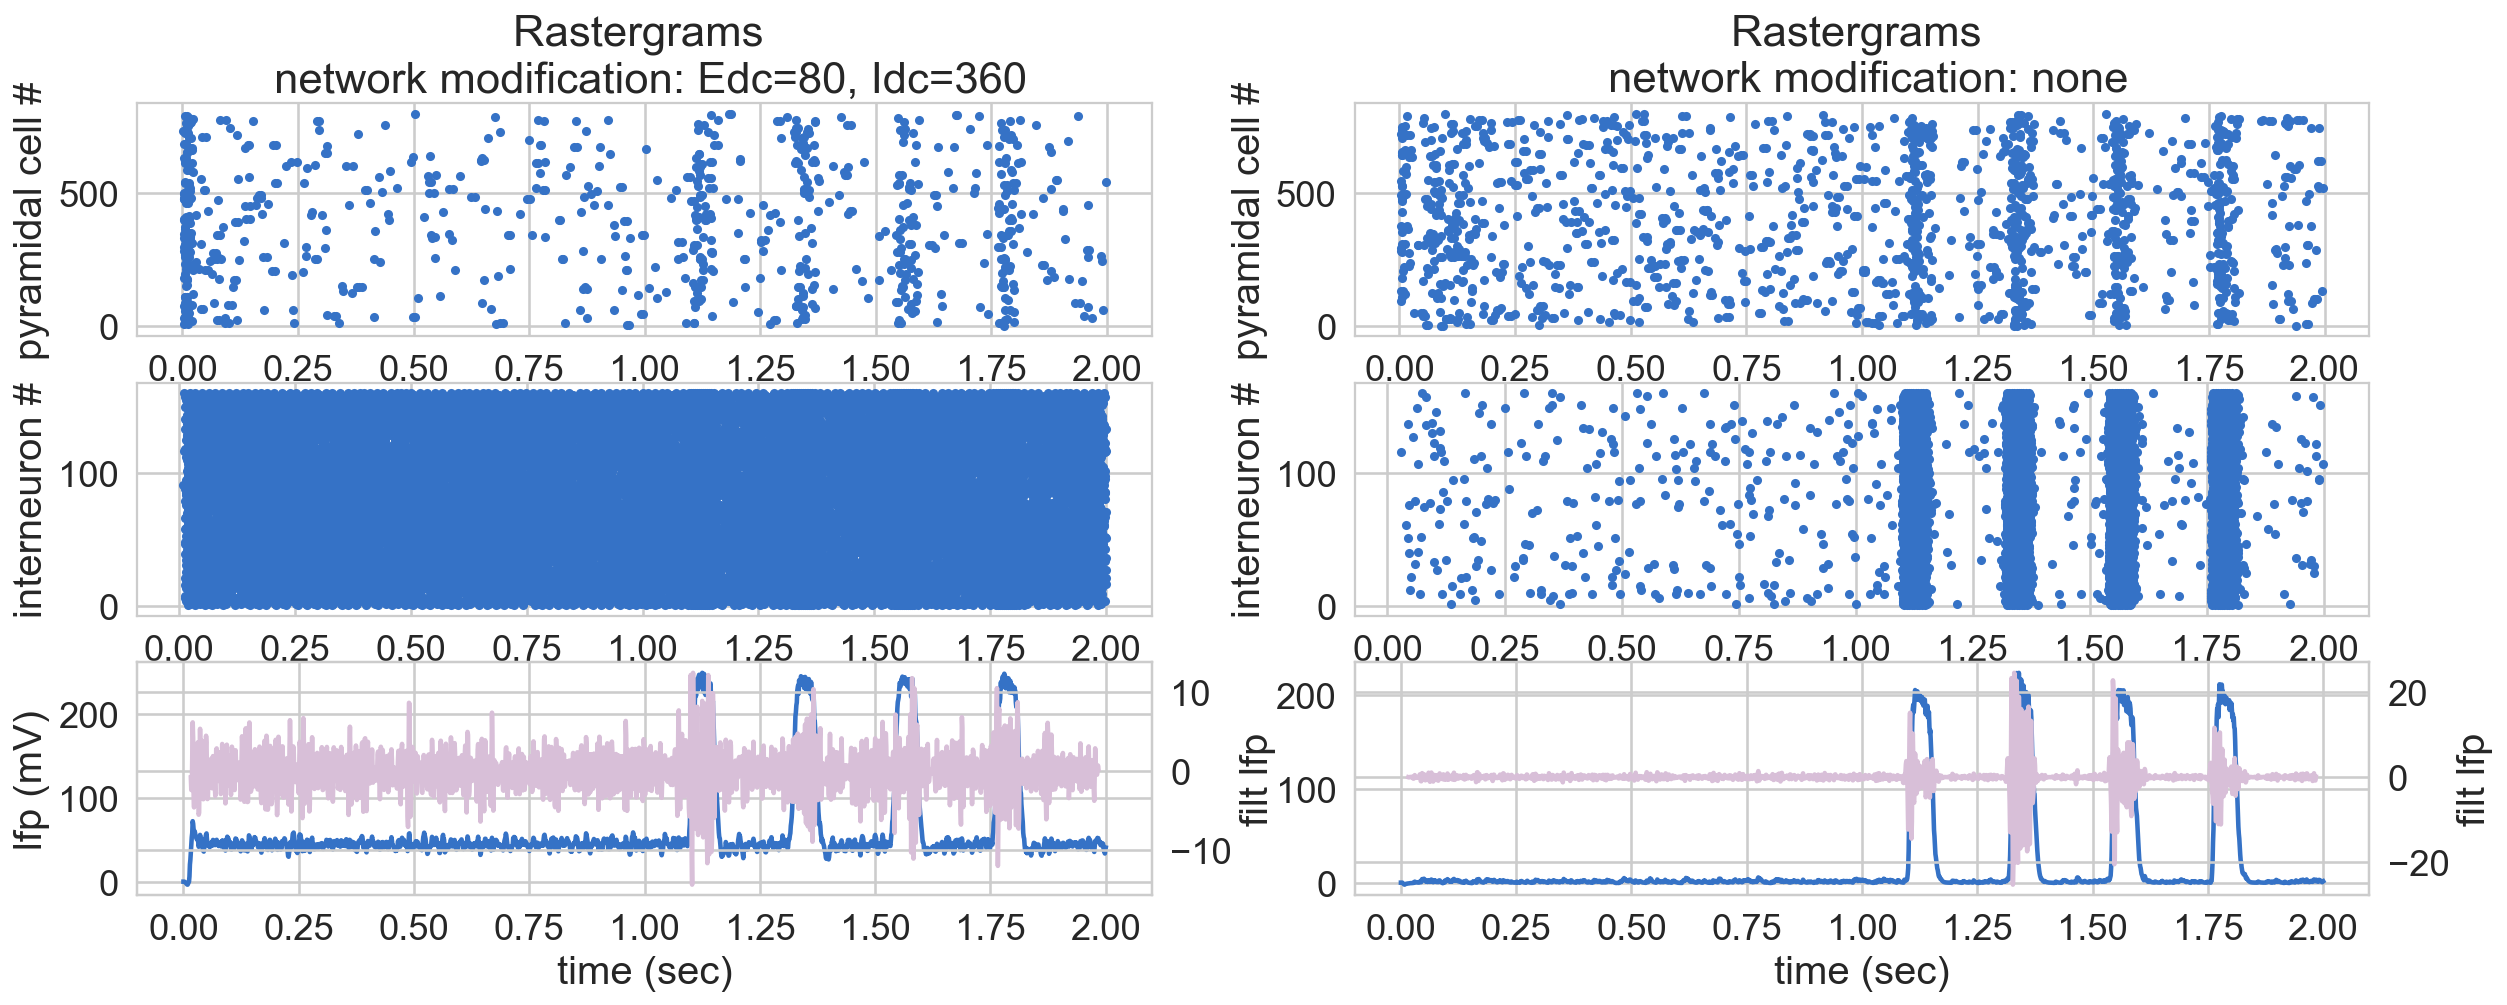

In [33]:
plt.figure()
plt.figure(figsize=(20,15))

plt.subplot(6,2,1)
plt.plot(df_Espktrns_Edctimes2Idctimes2['spktimes'], df_Espktrns_Edctimes2Idctimes2['cell_id'],'.')
plt.ylabel('pyramidal cell #')
plt.title('Rastergrams \n network modification: Edc=80, Idc=360')

plt.subplot(6,2,3)
plt.plot(df_Ispktrns_Edctimes2Idctimes2['spktimes'], df_Ispktrns_Edctimes2Idctimes2['cell_id'],'.')
plt.ylabel('interneuron #')

plt.subplot(6,2,2)
plt.plot(df_Espktrns['spktimes'], df_Espktrns['cell_id'],'.')
plt.ylabel('pyramidal cell #')
plt.title('Rastergrams \n network modification: none')

plt.subplot(6,2,4)
plt.plot(df_Ispktrns['spktimes'], df_Ispktrns['cell_id'],'.')
plt.ylabel('interneuron #')
plt.xlabel('time (sec)')

ax1 = plt.subplot(6,2,5)
plt.plot(df_lfp_Edctimes2Idctimes2['time'], df_lfp_Edctimes2Idctimes2['lfp'])
plt.ylabel('lfp (mV)')
plt.xlabel('time (sec)')
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('filt lfp')  # we already handled the x-label with ax1
ax2.plot(df_lfp_Edctimes2Idctimes2['time'],df_lfp_Edctimes2Idctimes2['filt lfp: ripple'],color='thistle')

ax1 = plt.subplot(6,2,6)
plt.plot(df_lfp['time'], df_lfp['lfp'])
plt.xlabel('time (sec)')
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('filt lfp')  # we already handled the x-label with ax1
ax2.plot(df_lfp['time'],df_lfp['filt lfp: ripple'],color='thistle')

<Figure size 460.8x403.2 with 0 Axes>

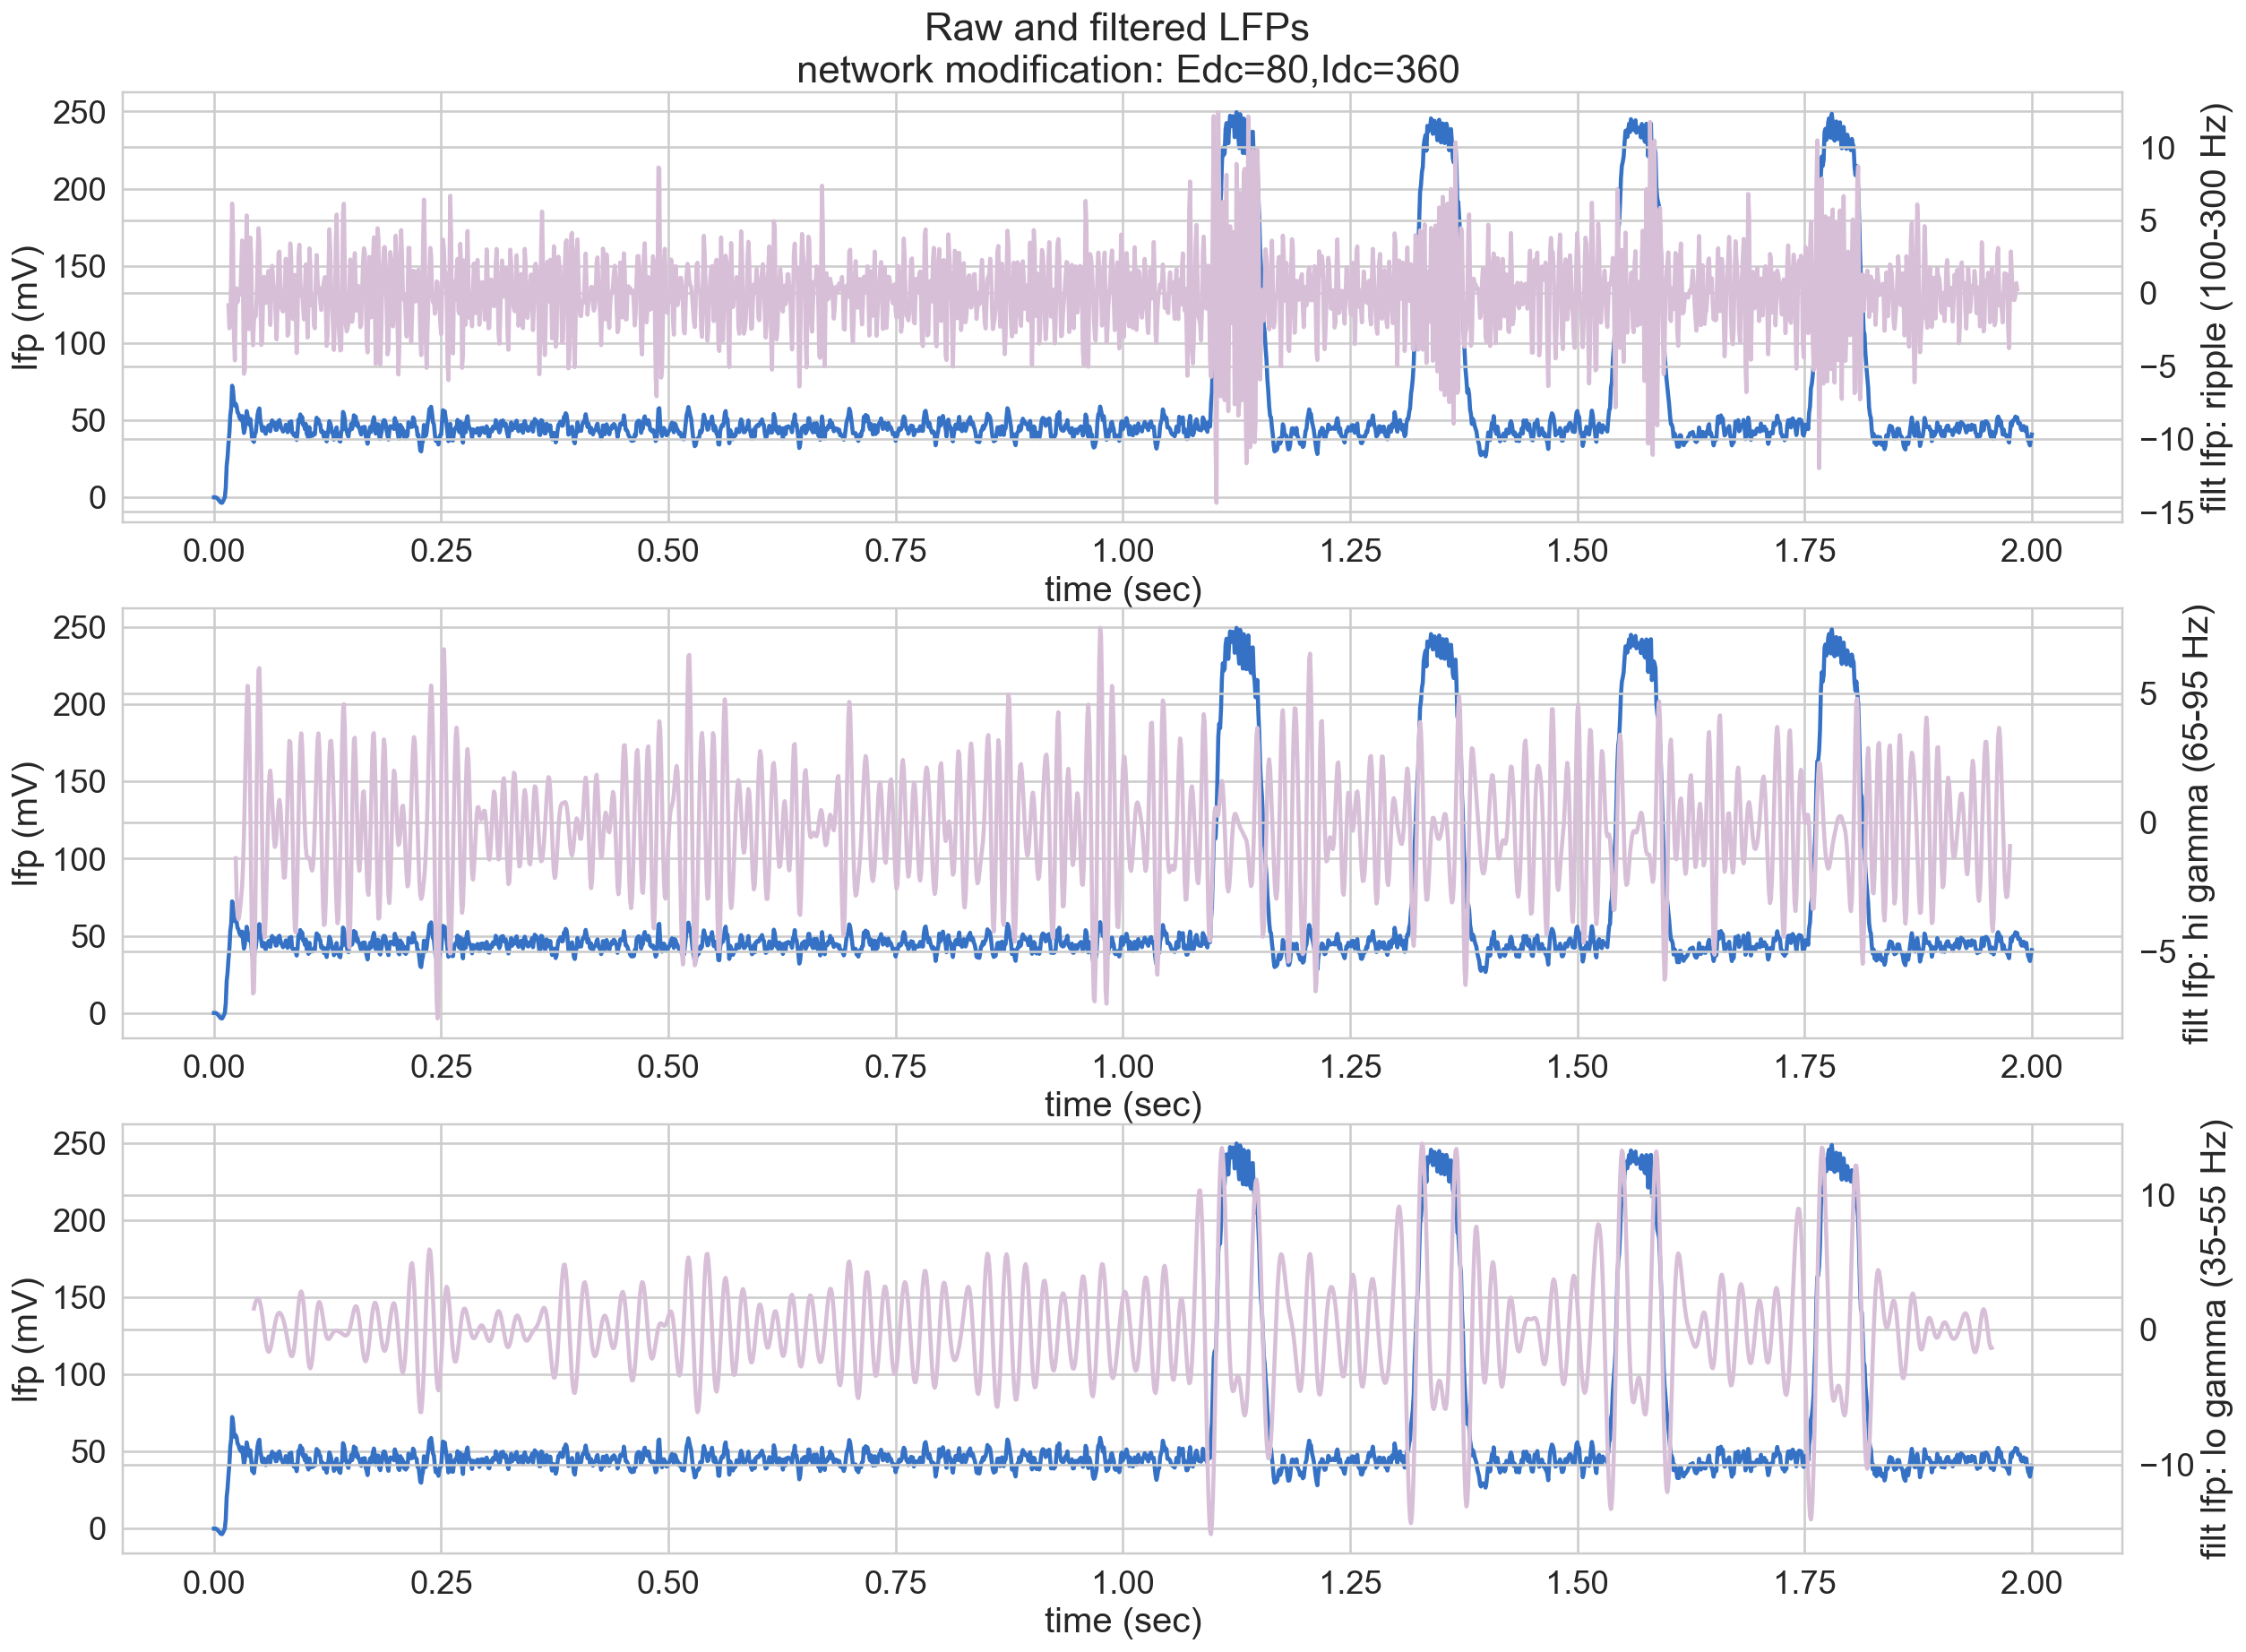

In [34]:
plt.figure()
plt.figure(figsize=(20,15))
sns.set_context("talk", font_scale=1.4)

ax1 = plt.subplot(3,1,1)
plt.plot(df_lfp_Edctimes2Idctimes2['time'], df_lfp_Edctimes2Idctimes2['lfp'])
plt.ylabel('lfp (mV)')
plt.xlabel('time (sec)')
plt.title('Raw and filtered LFPs \n network modification: Edc=80,Idc=360')
ax2 = ax1.twinx()  # instantiate a secEdctimes2ond axes that shares the same x-axis
ax2.set_ylabel('filt lfp: ripple (100-300 Hz)')  # we already handled the x-label with ax1
ax2.plot(df_lfp_Edctimes2Idctimes2['time'],df_lfp_Edctimes2Idctimes2['filt lfp: ripple'],color='thistle')

ax1 = plt.subplot(3,1,2)
plt.plot(df_lfp_Edctimes2Idctimes2['time'], df_lfp_Edctimes2Idctimes2['lfp'])
plt.ylabel('lfp (mV)')
plt.xlabel('time (sec)')
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('filt lfp: hi gamma (65-95 Hz)')  # we already handled the x-label with ax1
ax2.plot(df_lfp_Edctimes2Idctimes2['time'],df_lfp_Edctimes2Idctimes2['filt lfp: hi gamma'],color='thistle')

ax1 = plt.subplot(3,1,3)
plt.plot(df_lfp_Edctimes2Idctimes2['time'], df_lfp_Edctimes2Idctimes2['lfp'])
plt.ylabel('lfp (mV)')
plt.xlabel('time (sec)')
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('filt lfp: lo gamma (35-55 Hz)')  # we already handled the x-label with ax1
ax2.plot(df_lfp_Edctimes2Idctimes2['time'],df_lfp_Edctimes2Idctimes2['filt lfp: lo gamma'],color='thistle')



.
<br>
<br>
Overall, increasing the baseline excitability of the _interneurons_ seems to enhance high-frequency baseline activity in the network. 
<br>
<br>
Whether or not this baseline excitability truly constitutes a PING-like oscillation is unclear to me. Given that the pyramidal cells don't seem to have any particular rhythmicity (their firing doesn't seem to be organized according to any particular rhythm), I would say this is not truly a PING? 
<br>
.